In [20]:
import pandas as pd
import seaborn as sns
from pathlib import Path
import numpy as np
import joblib
import matplotlib.pyplot as plt
from tqdm import tqdm
import cv2
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.feature_selection import SelectKBest, f_regression, mutual_info_regression
from sklearn.multioutput import MultiOutputRegressor
from sklearn.metrics import mean_squared_error, r2_score
import xgboost as xgb
import lightgbm as lgb
from sklearn.linear_model
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
import tensorflow as tf
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.efficientnet import preprocess_input
from sklearn.utils import resample
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.ensemble import StackingRegressor, VotingRegressor
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor
from catboost import CatBoostRegressor
import optuna
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import load_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, Input
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import pickle
import joblib

In [21]:
df = pd.read_csv(r'C:\Users\David Hilbert\JupyterNotebook Projects\biomass_competition\train.csv')
df

,sample_id,image_path,Sampling_Date,State,Species,Pre_GSHH_NDVI,Height_Ave_cm,target_name,target
0,ID1011485656__Dry_Clover_g,train/ID1011485656.jpg,2015/9/4,Tas,Ryegrass_Clover,0.62,4.6667,Dry_Clover_g,0.0000
1,ID1011485656__Dry_Dead_g,train/ID1011485656.jpg,2015/9/4,Tas,Ryegrass_Clover,0.62,4.6667,Dry_Dead_g,31.9984
2,ID1011485656__Dry_Green_g,train/ID1011485656.jpg,2015/9/4,Tas,Ryegrass_Clover,0.62,4.6667,Dry_Green_g,16.2751
3,ID1011485656__Dry_Total_g,train/ID1011485656.jpg,2015/9/4,Tas,Ryegrass_Clover,0.62,4.6667,Dry_Total_g,48.2735
4,ID1011485656__GDM_g,train/ID1011485656.jpg,2015/9/4,Tas,Ryegrass_Clover,0.62,4.6667,GDM_g,16.2750
...,...,...,...,...,...,...,...,...,...
1780,ID983582017__Dry_Clover_g,train/ID983582017.jpg,2015/9/1,WA,Ryegrass,0.64,9.0000,Dry_Clover_g,0.0000
1781,ID983582017__Dry_Dead_g,train/ID983582017.jpg,2015/9/1,WA,Ryegrass,0.64,9.0000,Dry_Dead_g,0.0000
1782,ID983582017__Dry_Green_g,train/ID983582017.jpg,2015/9/1,WA,Ryegrass,0.64,9.0000,Dry_Green_g,40.9400
1783,ID983582017__Dry_Total_g,train/ID983582017.jpg,2015/9/1,WA,Ryegrass,0.64,9.0000,Dry_Total_g,40.9400


In [22]:
df = df.drop(['sample_id', 'Sampling_Date', 'State', 'Species', 'Pre_GSHH_NDVI', 'Height_Ave_cm'], axis=1)

In [23]:
df

,image_path,target_name,target
0,train/ID1011485656.jpg,Dry_Clover_g,0.0000
1,train/ID1011485656.jpg,Dry_Dead_g,31.9984
2,train/ID1011485656.jpg,Dry_Green_g,16.2751
3,train/ID1011485656.jpg,Dry_Total_g,48.2735
4,train/ID1011485656.jpg,GDM_g,16.2750
...,...,...,...
1780,train/ID983582017.jpg,Dry_Clover_g,0.0000
1781,train/ID983582017.jpg,Dry_Dead_g,0.0000
1782,train/ID983582017.jpg,Dry_Green_g,40.9400
1783,train/ID983582017.jpg,Dry_Total_g,40.9400


In [29]:
print("Анализ структуры данных:")
print("=" * 50)
print(f"Общий размер датафрейма: {df.shape}")
print(f"\nПервые 15 строк данных:")
print(df.head(15))

# Анализ уникальных значений target_name
print(f"\nУникальные значения target_name:")
print(df['target_name'].unique())
print(f"Количество уникальных target_name: {df['target_name'].nunique()}")

# Проверяем, всегда ли для каждого изображения ровно 5 компонентов
image_counts = df.groupby('image_path')['target_name'].nunique()
print(f"\nСтатистика по количеству компонентов на изображение:")
print(image_counts.value_counts().sort_index())

# Проверяем, одинаковы ли target_name для всех изображений
target_names_by_image = df.groupby('image_path')['target_name'].apply(set)
all_same = all(names == target_names_by_image.iloc[0] for names in target_names_by_image)
print(f"\nВсе изображения имеют одинаковые target_name: {all_same}")

if all_same:
    print(f"Уникальные компоненты: {sorted(target_names_by_image.iloc[0])}")

Анализ структуры данных:
Общий размер датафрейма: (1785, 3)

Первые 15 строк данных:
                image_path   target_name   target
0   train/ID1011485656.jpg  Dry_Clover_g   0.0000
1   train/ID1011485656.jpg    Dry_Dead_g  31.9984
2   train/ID1011485656.jpg   Dry_Green_g  16.2751
3   train/ID1011485656.jpg   Dry_Total_g  48.2735
4   train/ID1011485656.jpg         GDM_g  16.2750
5   train/ID1012260530.jpg  Dry_Clover_g   0.0000
6   train/ID1012260530.jpg    Dry_Dead_g   0.0000
7   train/ID1012260530.jpg   Dry_Green_g   7.6000
8   train/ID1012260530.jpg   Dry_Total_g   7.6000
9   train/ID1012260530.jpg         GDM_g   7.6000
10  train/ID1025234388.jpg  Dry_Clover_g   6.0500
11  train/ID1025234388.jpg    Dry_Dead_g   0.0000
12  train/ID1025234388.jpg   Dry_Green_g   0.0000
13  train/ID1025234388.jpg   Dry_Total_g   6.0500
14  train/ID1025234388.jpg         GDM_g   6.0500

Уникальные значения target_name:
['Dry_Clover_g' 'Dry_Dead_g' 'Dry_Green_g' 'Dry_Total_g' 'GDM_g']
Количество уник

In [31]:
def transform_to_wide_format(df):
    """Преобразуем данные из длинного в широкий формат"""
    print("\nТрансформация в широкий формат...")
    
    # Проверяем, есть ли дубликаты (один image_path + один target_name)
    duplicates = df.duplicated(subset=['image_path', 'target_name']).sum()
    if duplicates > 0:
        print(f"Найдено {duplicates} дубликатов по (image_path, target_name)")
        # Удаляем дубликаты, оставляя первое вхождение
        df = df.drop_duplicates(subset=['image_path', 'target_name'], keep='first')
    
    # Трансформируем в широкий формат
    df_wide = df.pivot(index='image_path', columns='target_name', values='target')
    
    # Сбрасываем индекс
    df_wide = df_wide.reset_index()
    
    # Переименовываем столбцы для удобства (убираем возможные пробелы и т.д.)
    df_wide.columns = ['image_path'] + [f'target_{col}' for col in df_wide.columns[1:]]
    
    print(f"Размер после трансформации: {df_wide.shape}")
    print(f"Столбцы: {list(df_wide.columns)}")
    
    return df_wide

# Трансформируем данные
df_wide = transform_to_wide_format(df)

# Проверяем результат
print("\nПервые 5 строк в широком формате:")
print(df_wide.head())

# Проверяем на пропуски
missing_values = df_wide.isnull().sum()
print(f"\nПропущенные значения по столбцам:")
print(missing_values[missing_values > 0])


Трансформация в широкий формат...
Размер после трансформации: (357, 6)
Столбцы: ['image_path', 'target_Dry_Clover_g', 'target_Dry_Dead_g', 'target_Dry_Green_g', 'target_Dry_Total_g', 'target_GDM_g']

Первые 5 строк в широком формате:
               image_path  target_Dry_Clover_g  target_Dry_Dead_g  \
0  train/ID1011485656.jpg               0.0000            31.9984   
1  train/ID1012260530.jpg               0.0000             0.0000   
2  train/ID1025234388.jpg               6.0500             0.0000   
3  train/ID1028611175.jpg               0.0000            30.9703   
4  train/ID1035947949.jpg               0.4343            23.2239   

   target_Dry_Green_g  target_Dry_Total_g  target_GDM_g  
0             16.2751             48.2735       16.2750  
1              7.6000              7.6000        7.6000  
2              0.0000              6.0500        6.0500  
3             24.2376             55.2079       24.2376  
4             10.5261             34.1844       10.9605  

П


Анализ распределения целевых переменных:


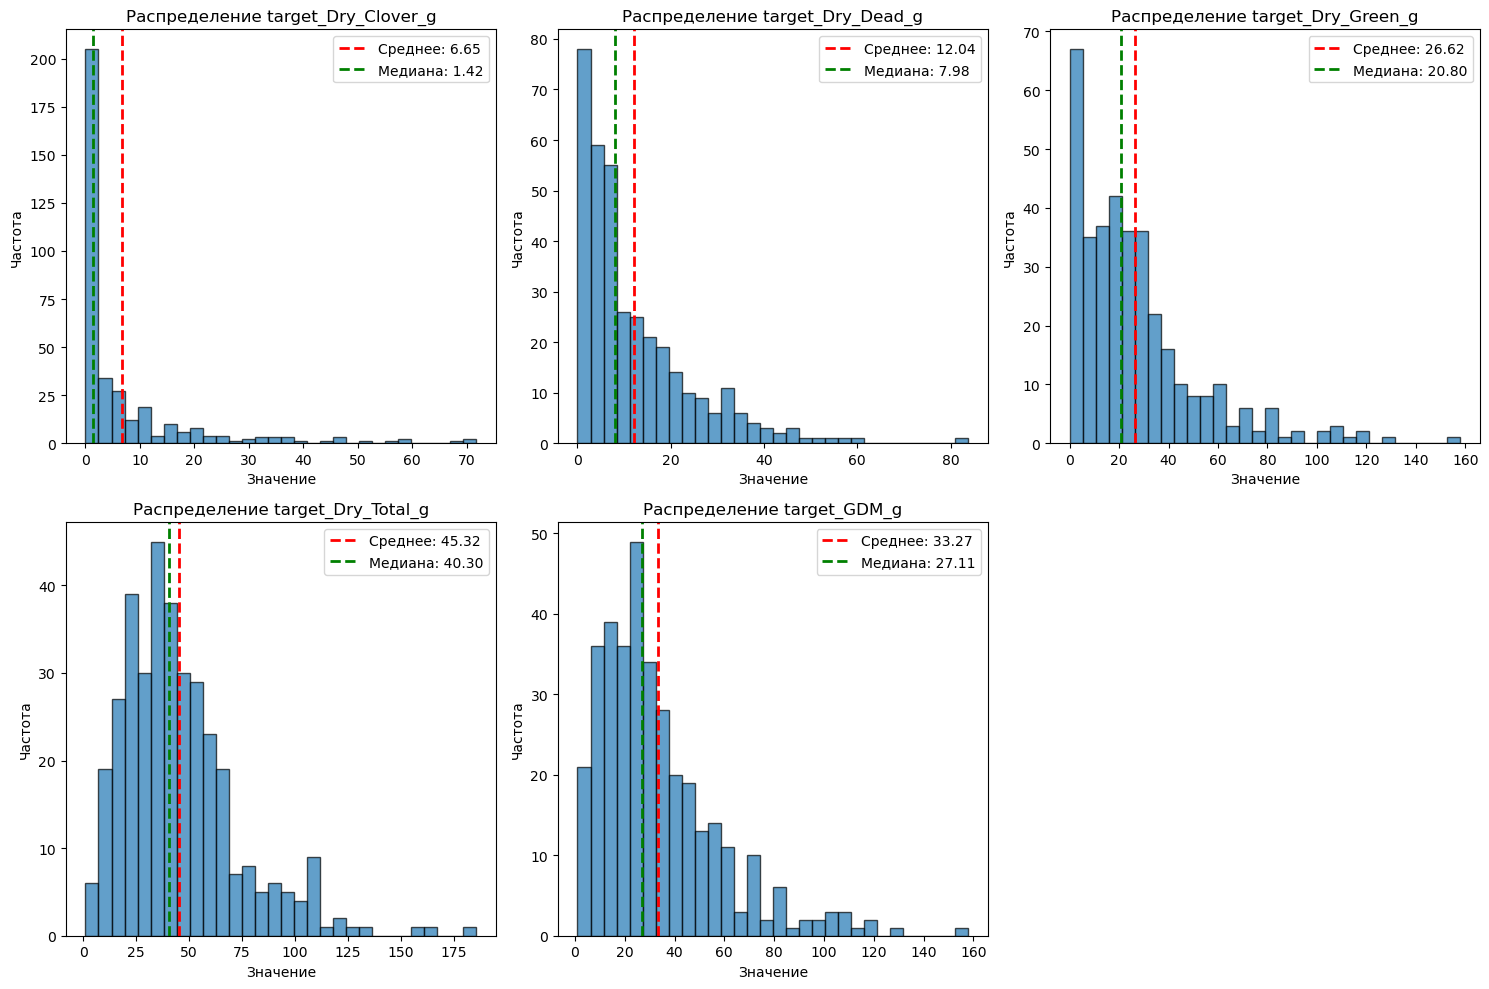


Статистика по целевым переменным:
          Компонент   Среднее  Медиана  Стандартное отклонение  Минимум  Максимум  Количество  Пропуски
target_Dry_Clover_g  6.649692   1.4235               12.117761     0.00   71.7865         357         0
  target_Dry_Dead_g 12.044548   7.9809               12.402007     0.00   83.8407         357         0
 target_Dry_Green_g 26.624722  20.8000               25.401232     0.00  157.9836         357         0
 target_Dry_Total_g 45.318097  40.3000               27.984015     1.04  185.7000         357         0
       target_GDM_g 33.274414  27.1082               24.935822     1.04  157.9836         357         0


In [33]:
def analyze_target_distributions(df_wide):
    """Анализируем распределение каждого компонента биомассы"""
    target_cols = [col for col in df_wide.columns if col.startswith('target_')]
    
    print(f"\nАнализ распределения целевых переменных:")
    print("=" * 60)
    
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    axes = axes.flatten()
    
    stats_data = []
    
    for i, target_col in enumerate(target_cols):
        if i >= len(axes):
            break
            
        data = df_wide[target_col].dropna()
        
        # Статистика
        stats = {
            'Компонент': target_col,
            'Среднее': data.mean(),
            'Медиана': data.median(),
            'Стандартное отклонение': data.std(),
            'Минимум': data.min(),
            'Максимум': data.max(),
            'Количество': len(data),
            'Пропуски': df_wide[target_col].isnull().sum()
        }
        stats_data.append(stats)
        
        # Визуализация
        ax = axes[i]
        ax.hist(data, bins=30, edgecolor='black', alpha=0.7)
        ax.set_title(f'Распределение {target_col}', fontsize=12)
        ax.set_xlabel('Значение')
        ax.set_ylabel('Частота')
        
        # Добавляем вертикальные линии для среднего и медианы
        ax.axvline(data.mean(), color='red', linestyle='--', linewidth=2, label=f'Среднее: {data.mean():.2f}')
        ax.axvline(data.median(), color='green', linestyle='--', linewidth=2, label=f'Медиана: {data.median():.2f}')
        ax.legend()
    
    # Скрываем неиспользуемые subplots
    for j in range(len(target_cols), len(axes)):
        axes[j].set_visible(False)
    
    plt.tight_layout()
    plt.show()
    
    # Выводим статистику в таблице
    stats_df = pd.DataFrame(stats_data)
    print("\nСтатистика по целевым переменным:")
    print(stats_df.to_string(index=False))
    
    return target_cols

# Запускаем анализ
target_cols = analyze_target_distributions(df_wide)


Матрица корреляций между компонентами биомассы:
                     target_Dry_Clover_g  target_Dry_Dead_g  \
target_Dry_Clover_g                1.000             -0.176   
target_Dry_Dead_g                 -0.176              1.000   
target_Dry_Green_g                -0.277              0.096   
target_Dry_Total_g                 0.104              0.454   
target_GDM_g                       0.204              0.012   

                     target_Dry_Green_g  target_Dry_Total_g  target_GDM_g  
target_Dry_Clover_g              -0.277               0.104         0.204  
target_Dry_Dead_g                 0.096               0.454         0.012  
target_Dry_Green_g                1.000               0.830         0.884  
target_Dry_Total_g                0.830               1.000         0.896  
target_GDM_g                      0.884               0.896         1.000  


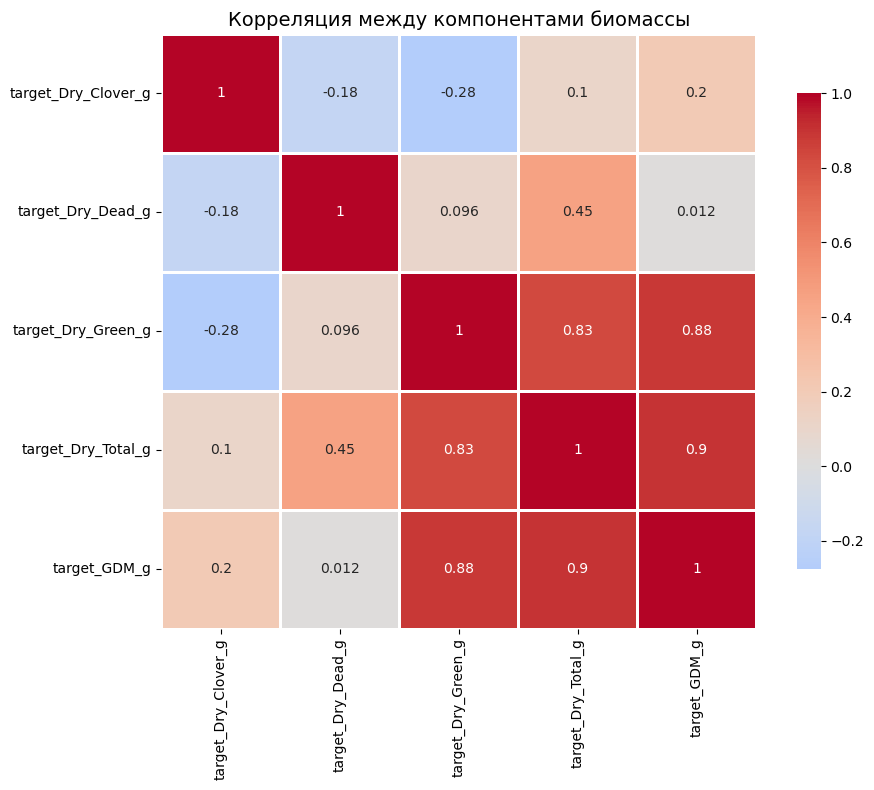


Сильно коррелированные пары (|r| > 0.7):
  target_Dry_Green_g - target_Dry_Total_g: 0.830
  target_Dry_Green_g - target_GDM_g: 0.884
  target_Dry_Total_g - target_GDM_g: 0.896


In [35]:
def analyze_correlations(df_wide, target_cols):
    """Анализируем корреляции между различными компонентами биомассы"""
    
    # Матрица корреляций
    corr_matrix = df_wide[target_cols].corr()
    
    print("\nМатрица корреляций между компонентами биомассы:")
    print(corr_matrix.round(3))
    
    # Визуализация
    plt.figure(figsize=(10, 8))
    sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0, 
                square=True, linewidths=1, cbar_kws={"shrink": 0.8})
    plt.title('Корреляция между компонентами биомассы', fontsize=14)
    plt.tight_layout()
    plt.show()
    
    # Анализ сильно коррелированных признаков
    print("\nСильно коррелированные пары (|r| > 0.7):")
    high_corr_pairs = []
    for i in range(len(target_cols)):
        for j in range(i+1, len(target_cols)):
            corr_value = corr_matrix.iloc[i, j]
            if abs(corr_value) > 0.7:
                high_corr_pairs.append((target_cols[i], target_cols[j], corr_value))
    
    for pair in high_corr_pairs:
        print(f"  {pair[0]} - {pair[1]}: {pair[2]:.3f}")
    
    return corr_matrix

corr_matrix = analyze_correlations(df_wide, target_cols)

In [37]:
def extract_enhanced_features(image_path, target_names):
    """
    Улучшенное извлечение признаков с учётом специфики компонентов биомассы
    
    target_names: список имён компонентов для данного изображения
    """
    features = {}
    
    try:
        img = cv2.imread(image_path)
        if img is None:
            return None
            
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        h, w, c = img.shape
        
        # Базовые признаки изображения
        features.update({
            'image_height': h,
            'image_width': w,
            'aspect_ratio': w / h if h > 0 else 0
        })
        
        # 1. Признаки, специфичные для растительности
        # Разделение каналов
        R = img[:, :, 0].astype(float)
        G = img[:, :, 1].astype(float)
        B = img[:, :, 2].astype(float)
        
        # Вегетационные индексы (крайне важны для биомассы)
        with np.errstate(divide='ignore', invalid='ignore'):
            # NDVI-like индекс для RGB (Modified)
            denominator = (R + G + B + 1e-7)
            
            # Excess Green Index
            ExG = 2 * G - R - B
            features['ExG_mean'] = np.mean(ExG / denominator)
            features['ExG_std'] = np.std(ExG / denominator)
            
            # Excess Red Index
            ExR = 1.4 * R - G
            features['ExR_mean'] = np.mean(ExR / denominator)
            
            # Normalized Green-Red Difference Index (NGRDI)
            NGRDI = (G - R) / (G + R + 1e-7)
            features['NGRDI_mean'] = np.mean(NGRDI)
            features['NGRDI_std'] = np.std(NGRDI)
            
            # Vegetative Index (VEG)
            VEG = G / (R**0.667 * B**0.333 + 1e-7)
            features['VEG_mean'] = np.mean(VEG)
            
            # Color Index of Vegetation (CIVE)
            CIVE = 0.441*R - 0.811*G + 0.385*B + 18.78745
            features['CIVE_mean'] = np.mean(CIVE)
        
        # 2. Признаки текстуры и структуры (важны для оценки плотности)
        gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        
        # GLCM признаки
        from skimage.feature import graycomatrix, graycoprops
        
        # Квантование для уменьшения количества уровней серого
        gray_quantized = (gray / 32).astype(np.uint8)  # 8 уровней
        
        glcm = graycomatrix(gray_quantized, 
                           distances=[1, 3, 5], 
                           angles=[0, np.pi/4, np.pi/2, 3*np.pi/4],
                           levels=8, 
                           symmetric=True, 
                           normed=True)
        
        # Средние значения по всем расстояниям и углам
        for prop in ['contrast', 'dissimilarity', 'homogeneity', 'energy', 'correlation']:
            prop_values = graycoprops(glcm, prop)
            features[f'glcm_{prop}_mean'] = np.mean(prop_values)
            features[f'glcm_{prop}_std'] = np.std(prop_values)
        
        # 3. Признаки сегментации растительности
        # Простая пороговая сегментация по зеленому
        hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        
        # Маска для зеленого цвета
        lower_green = np.array([35, 40, 40])
        upper_green = np.array([85, 255, 255])
        green_mask = cv2.inRange(hsv, lower_green, upper_green)
        
        # Признаки на основе маски
        green_pixels = np.sum(green_mask > 0)
        features['green_area'] = green_pixels
        features['green_coverage'] = green_pixels / (h * w)
        
        # Контуры зеленых областей
        contours, _ = cv2.findContours(green_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        features['num_green_contours'] = len(contours)
        
        if contours:
            areas = [cv2.contourArea(cnt) for cnt in contours]
            features['avg_contour_area'] = np.mean(areas)
            features['max_contour_area'] = np.max(areas)
        
        # 4. Признаки цвета в различных пространствах
        # LAB пространство (важно для восприятия цвета)
        lab = cv2.cvtColor(img, cv2.COLOR_RGB2LAB)
        L, A, B = cv2.split(lab)
        
        features.update({
            'L_mean': np.mean(L), 'L_std': np.std(L),
            'A_mean': np.mean(A), 'A_std': np.std(A),
            'B_mean': np.mean(B), 'B_std': np.std(B),
        })
        
        # 5. Статистические признаки градиентов
        sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=3)
        sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=3)
        gradient_magnitude = np.sqrt(sobelx**2 + sobely**2)
        
        features.update({
            'gradient_mean': np.mean(gradient_magnitude),
            'gradient_std': np.std(gradient_magnitude),
            'gradient_max': np.max(gradient_magnitude)
        })
        
        # 6. Признаки, основанные на энтропии (сложность текстуры)
        from skimage.measure import shannon_entropy
        features['entropy'] = shannon_entropy(gray)
        
        # 7. Пространственные признаки (размеры связанных компонентов)
        num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(green_mask, 8, cv2.CV_32S)
        if num_labels > 1:  # исключаем фон
            component_sizes = stats[1:, cv2.CC_STAT_AREA]
            features.update({
                'num_green_components': num_labels - 1,
                'avg_component_size': np.mean(component_sizes),
                'largest_component': np.max(component_sizes),
                'component_size_std': np.std(component_sizes)
            })
        
        # 8. Признаки гистограммы цвета
        for i, (channel, name) in enumerate(zip([R, G, B], ['R', 'G', 'B'])):
            hist = cv2.calcHist([channel.astype(np.uint8)], [0], None, [8], [0, 256]).flatten()
            hist = hist / hist.sum()  # нормализация
            
            # Первые 4 бина гистограммы
            for j in range(4):
                features[f'hist_{name}_{j}'] = hist[j]
            
            # Моменты гистограммы
            features[f'hist_{name}_skew'] = pd.Series(channel.flatten()).skew()
        
    except Exception as e:
        print(f"Ошибка при обработке {image_path}: {e}")
        return None
    
    return features

In [43]:
def create_multitask_dataset(df_wide, sample_size=None):
    """Создание датасета для многозадачной регрессии"""
    print("\nСоздание датасета с признаками изображений...")
    
    all_features = []
    valid_paths = []
    
    paths = df_wide['image_path'].values
    if sample_size and sample_size < len(paths):
        paths = paths[:sample_size]
    
    for path in tqdm(paths, desc="Извлечение признаков"):
        features = extract_enhanced_features(path, target_cols)
        if features:
            all_features.append(features)
            valid_paths.append(path)
    
    # Создаем DataFrame с признаками
    features_df = pd.DataFrame(all_features)
    features_df['image_path'] = valid_paths
    
    # Объединяем с целевыми переменными
    merged_df = pd.merge(features_df, df_wide, on='image_path', how='inner')
    
    print(f"\nИтоговый размер датасета: {merged_df.shape}")
    print(f"Количество признаков: {len([col for col in merged_df.columns if col not in ['image_path'] + target_cols])}")
    print(f"Целевые переменные: {target_cols}")
    
    return merged_df

# Создаем финальный датасет
final_df = create_multitask_dataset(df_wide)

# Сохраняем для дальнейшего использования
final_df.to_csv('biomass_features_dataset.csv', index=False)
print("\nДатасет сохранен как 'biomass_features_dataset.csv'")


Создание датасета с признаками изображений...


Извлечение признаков: 100%|██████████| 357/357 [04:10<00:00,  1.42it/s]


Итоговый размер датасета: (357, 60)
Количество признаков: 54
Целевые переменные: ['target_Dry_Clover_g', 'target_Dry_Dead_g', 'target_Dry_Green_g', 'target_Dry_Total_g', 'target_GDM_g']

Датасет сохранен как 'biomass_features_dataset.csv'


In [45]:
def prepare_multitask_data(final_df, target_cols, test_size=0.2, random_state=42):
    """Подготовка данных для многозадачного обучения"""
    
    # Отделяем признаки и цели
    X = final_df.drop(['image_path'] + target_cols, axis=1)
    y = final_df[target_cols]
    
    # Заполняем пропуски
    X = X.fillna(X.median())
    
    print(f"\nПодготовка данных:")
    print(f"Признаков: {X.shape[1]}")
    print(f"Образцов: {X.shape[0]}")
    
    # Масштабирование признаков
    # RobustScaler менее чувствителен к выбросам
    scaler = RobustScaler()
    X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)
    
    # Отбор признаков для каждой задачи
    print("\nОтбор признаков для каждого компонента...")
    selected_features_by_target = {}
    
    for target in target_cols:
        print(f"\n{target}:")
        y_target = y[target]
        
        # Используем mutual information для отбора признаков
        selector = SelectKBest(score_func=mutual_info_regression, k='all')
        selector.fit(X_scaled, y_target)
        
        # Сортируем признаки по важности
        feature_scores = pd.DataFrame({
            'feature': X.columns,
            'score': selector.scores_
        }).sort_values('score', ascending=False)
        
        # Выбираем топ-N признаков
        top_n = min(50, X.shape[1])
        top_features = feature_scores.head(top_n)['feature'].tolist()
        selected_features_by_target[target] = top_features
        
        print(f"  Топ-10 признаков:")
        for i, (feature, score) in enumerate(feature_scores.head(10).values):
            print(f"    {i+1}. {feature}: {score:.4f}")
    
    # Объединяем все выбранные признаки
    all_selected_features = set()
    for features in selected_features_by_target.values():
        all_selected_features.update(features)
    
    print(f"\nВсего уникальных выбранных признаков: {len(all_selected_features)}")
    
    # Используем объединенный набор признаков
    X_final = X_scaled[list(all_selected_features)]
    
    # Разделение на train/test
    X_train, X_test, y_train, y_test = train_test_split(
        X_final, y, test_size=test_size, random_state=random_state, stratify=None
    )
    
    print(f"\nРазделение данных:")
    print(f"  Train: {X_train.shape}")
    print(f"  Test: {X_test.shape}")
    
    return X_train, X_test, y_train, y_test, list(all_selected_features)

# Подготавливаем данные
X_train, X_test, y_train, y_test, selected_features = prepare_multitask_data(final_df, target_cols)


Подготовка данных:
Признаков: 54
Образцов: 357

Отбор признаков для каждого компонента...

target_Dry_Clover_g:
  Топ-10 признаков:
    1. glcm_correlation_std: 0.1908
    2. glcm_homogeneity_mean: 0.1609
    3. gradient_max: 0.1444
    4. glcm_energy_mean: 0.1404
    5. gradient_mean: 0.1392
    6. glcm_dissimilarity_std: 0.1268
    7. glcm_correlation_mean: 0.1188
    8. A_std: 0.1142
    9. CIVE_mean: 0.1077
    10. component_size_std: 0.1071

target_Dry_Dead_g:
  Топ-10 признаков:
    1. hist_B_skew: 0.2140
    2. glcm_homogeneity_std: 0.1555
    3. max_contour_area: 0.1461
    4. num_green_contours: 0.1426
    5. avg_contour_area: 0.1228
    6. B_mean: 0.1228
    7. VEG_mean: 0.1204
    8. L_mean: 0.1157
    9. green_coverage: 0.1020
    10. green_area: 0.1020

target_Dry_Green_g:
  Топ-10 признаков:
    1. glcm_correlation_mean: 0.2805
    2. A_mean: 0.2429
    3. CIVE_mean: 0.2067
    4. max_contour_area: 0.1880
    5. glcm_homogeneity_mean: 0.1827
    6. green_coverage: 0.1722

In [47]:
def evaluate_multitask_models(X_train, X_test, y_train, y_test, target_cols):
    """Оценка различных подходов к многозадачной регрессии"""
    
    results = {}
    
    # 1. MultiOutputRegressor с XGBoost (отдельная модель для каждой задачи)
    print("\n" + "="*60)
    print("1. MultiOutputRegressor с XGBoost")
    print("="*60)
    
    xgb_base = xgb.XGBRegressor(
        n_estimators=300,
        learning_rate=0.05,
        max_depth=6,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42,
        n_jobs=-1
    )
    
    multi_xgb = MultiOutputRegressor(xgb_base)
    multi_xgb.fit(X_train, y_train)
    
    y_pred = multi_xgb.predict(X_test)
    
    # Метрики для каждой задачи
    xgb_results = {}
    for i, target in enumerate(target_cols):
        r2 = r2_score(y_test[target].values, y_pred[:, i])
        rmse = np.sqrt(mean_squared_error(y_test[target].values, y_pred[:, i]))
        xgb_results[target] = {'R2': r2, 'RMSE': rmse}
    
    results['Multi_XGBoost'] = xgb_results
    
    # 2. Random Forest с multi-output
    print("\n" + "="*60)
    print("2. Random Forest (встроенная многозадачность)")
    print("="*60)
    
    rf = RandomForestRegressor(
        n_estimators=300,
        max_depth=15,
        min_samples_split=5,
        min_samples_leaf=2,
        random_state=42,
        n_jobs=-1
    )
    
    rf.fit(X_train, y_train)
    y_pred_rf = rf.predict(X_test)
    
    rf_results = {}
    for i, target in enumerate(target_cols):
        r2 = r2_score(y_test[target].values, y_pred_rf[:, i])
        rmse = np.sqrt(mean_squared_error(y_test[target].values, y_pred_rf[:, i]))
        rf_results[target] = {'R2': r2, 'RMSE': rmse}
    
    results['RandomForest'] = rf_results
    
    # 3. LightGBM с multi-output через MultiOutputRegressor
    print("\n" + "="*60)
    print("3. LightGBM через MultiOutputRegressor")
    print("="*60)
    
    lgb_base = lgb.LGBMRegressor(
        n_estimators=300,
        learning_rate=0.05,
        max_depth=6,
        num_leaves=31,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42,
        n_jobs=-1
    )
    
    multi_lgb = MultiOutputRegressor(lgb_base)
    multi_lgb.fit(X_train, y_train)
    
    y_pred_lgb = multi_lgb.predict(X_test)
    
    lgb_results = {}
    for i, target in enumerate(target_cols):
        r2 = r2_score(y_test[target].values, y_pred_lgb[:, i])
        rmse = np.sqrt(mean_squared_error(y_test[target].values, y_pred_lgb[:, i]))
        lgb_results[target] = {'R2': r2, 'RMSE': rmse}
    
    results['LightGBM'] = lgb_results
    
    # 4. Stacking моделей для каждой задачи
    print("\n" + "="*60)
    print("4. Ансамбль моделей")
    print("="*60)
    
    # Для каждой задачи создаем ансамбль предсказаний
    y_pred_ensemble = np.zeros_like(y_pred)
    
    for i in range(len(target_cols)):
        # Среднее предсказаний трех моделей
        y_pred_ensemble[:, i] = (y_pred[:, i] + y_pred_rf[:, i] + y_pred_lgb[:, i]) / 3
    
    ensemble_results = {}
    for i, target in enumerate(target_cols):
        r2 = r2_score(y_test[target].values, y_pred_ensemble[:, i])
        rmse = np.sqrt(mean_squared_error(y_test[target].values, y_pred_ensemble[:, i]))
        ensemble_results[target] = {'R2': r2, 'RMSE': rmse}
    
    results['Ensemble'] = ensemble_results
    
    # Вывод результатов
    print("\n" + "="*80)
    print("СРАВНЕНИЕ РЕЗУЛЬТАТОВ ПО КОМПОНЕНТАМ")
    print("="*80)
    
    summary_df = pd.DataFrame()
    
    for target in target_cols:
        target_results = []
        for model_name in results.keys():
            r2 = results[model_name][target]['R2']
            target_results.append(f"{r2:.4f}")
        
        summary_df[target] = target_results
    
    summary_df.index = results.keys()
    
    print("\nR² score по моделям и компонентам:")
    print(summary_df)
    
    # Средний R² по всем компонентам
    print("\nСредний R² по всем компонентам:")
    for model_name in results.keys():
        avg_r2 = np.mean([results[model_name][target]['R2'] for target in target_cols])
        print(f"  {model_name}: {avg_r2:.4f}")
    
    return results, summary_df

# Запускаем оценку моделей
results, summary_df = evaluate_multitask_models(X_train, X_test, y_train, y_test, target_cols)


1. MultiOutputRegressor с XGBoost

2. Random Forest (встроенная многозадачность)

3. LightGBM через MultiOutputRegressor
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000450 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4606
[LightGBM] [Info] Number of data points in the train set: 285, number of used features: 49
[LightGBM] [Info] Start training from score 6.255047
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [W

Лучший компонент: target_GDM_g, Лучшая модель: Ensemble, R²: 0.5468


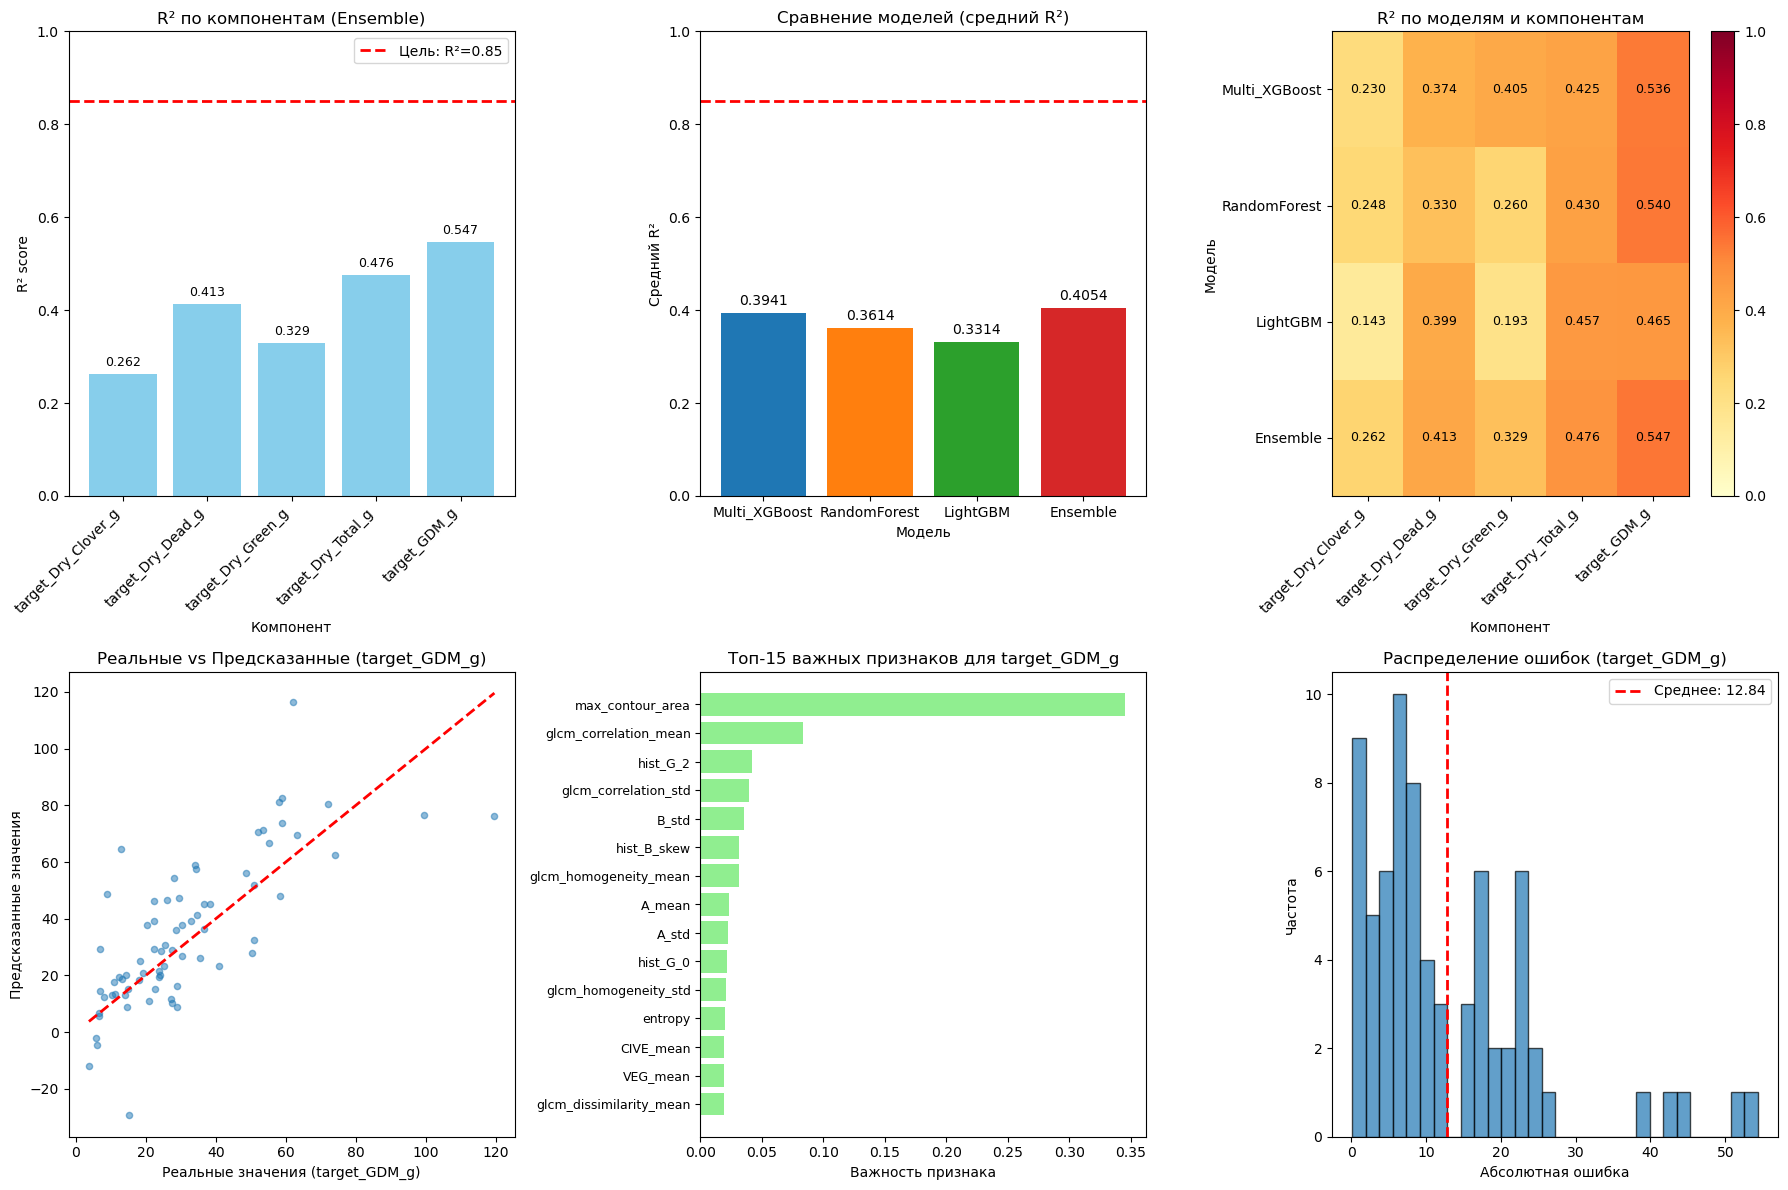


Итоговые результаты:
Лучший компонент: target_GDM_g
Лучшая модель: Ensemble
Лучший R²: 0.5468


In [53]:
def visualize_results(results, target_cols, X_train, X_test, y_train, y_test, selected_features):
    """Визуализация результатов моделей"""
    
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    axes = axes.flatten()
    
    # 1. Сравнение R² по компонентам для лучшей модели
    ax1 = axes[0]
    model_name = 'Ensemble' if 'Ensemble' in results else list(results.keys())[0]
    
    r2_values = [results[model_name][target]['R2'] for target in target_cols]
    bars = ax1.bar(range(len(target_cols)), r2_values, color='skyblue')
    ax1.set_xlabel('Компонент')
    ax1.set_ylabel('R² score')
    ax1.set_title(f'R² по компонентам ({model_name})')
    ax1.set_xticks(range(len(target_cols)))
    ax1.set_xticklabels(target_cols, rotation=45, ha='right')
    ax1.axhline(y=0.85, color='red', linestyle='--', linewidth=2, label='Цель: R²=0.85')
    
    # Добавляем значения на столбцы
    for bar, val in zip(bars, r2_values):
        height = bar.get_height()
        ax1.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                f'{val:.3f}', ha='center', va='bottom', fontsize=9)
    
    ax1.legend()
    ax1.set_ylim([0, 1.0])
    
    # 2. Сравнение среднего R² по моделям
    ax2 = axes[1]
    model_names = list(results.keys())
    avg_r2_scores = []
    
    for model_name in model_names:
        avg_r2 = np.mean([results[model_name][target]['R2'] for target in target_cols])
        avg_r2_scores.append(avg_r2)
    
    bars2 = ax2.bar(model_names, avg_r2_scores, color=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728'])
    ax2.set_xlabel('Модель')
    ax2.set_ylabel('Средний R²')
    ax2.set_title('Сравнение моделей (средний R²)')
    ax2.axhline(y=0.85, color='red', linestyle='--', linewidth=2)
    
    for bar, val in zip(bars2, avg_r2_scores):
        height = bar.get_height()
        ax2.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                f'{val:.4f}', ha='center', va='bottom', fontsize=10)
    
    ax2.set_ylim([0, 1.0])
    
    # 3. Матрица сравнения моделей по компонентам (тепловая карта)
    ax3 = axes[2]
    r2_matrix = []
    
    for model_name in model_names:
        model_r2 = [results[model_name][target]['R2'] for target in target_cols]
        r2_matrix.append(model_r2)
    
    im = ax3.imshow(r2_matrix, cmap='YlOrRd', aspect='auto', vmin=0, vmax=1)
    ax3.set_xlabel('Компонент')
    ax3.set_ylabel('Модель')
    ax3.set_title('R² по моделям и компонентам')
    ax3.set_xticks(range(len(target_cols)))
    ax3.set_xticklabels(target_cols, rotation=45, ha='right')
    ax3.set_yticks(range(len(model_names)))
    ax3.set_yticklabels(model_names)
    
    # Добавляем значения в ячейки
    for i in range(len(model_names)):
        for j in range(len(target_cols)):
            text = ax3.text(j, i, f'{r2_matrix[i][j]:.3f}',
                          ha="center", va="center", color="black", fontsize=9)
    
    plt.colorbar(im, ax=ax3)
    
    # 4. Реальные vs Предсказанные значения для лучшего компонента
    ax4 = axes[3]
    
    # Находим компонент с лучшим R²
    best_target = None
    best_r2 = -1
    best_model_name = None
    
    # Ищем лучший компонент и лучшую модель для него
    for target in target_cols:
        for model_name in model_names:
            if results[model_name][target]['R2'] > best_r2:
                best_r2 = results[model_name][target]['R2']
                best_target = target
                best_model_name = model_name
    
    print(f"Лучший компонент: {best_target}, Лучшая модель: {best_model_name}, R²: {best_r2:.4f}")
    
    # Поскольку у нас нет сохраненных предсказаний, используем простую модель для демонстрации
    # В реальном коде нужно сохранять предсказания моделей
    
    # Создаем упрощенную версию графика с использованием LinearRegression
    lr = LinearRegression()
    lr.fit(X_train, y_train[best_target])
    y_pred_simple = lr.predict(X_test)
    
    ax4.scatter(y_test[best_target], y_pred_simple, alpha=0.5, s=20)
    ax4.plot([y_test[best_target].min(), y_test[best_target].max()],
             [y_test[best_target].min(), y_test[best_target].max()],
             'r--', linewidth=2)
    ax4.set_xlabel(f'Реальные значения ({best_target})')
    ax4.set_ylabel(f'Предсказанные значения')
    ax4.set_title(f'Реальные vs Предсказанные ({best_target})')
    
    # 5. Важность признаков для лучшей модели (используем XGBoost как пример)
    ax5 = axes[4]
    
    # Обучение XGBoost для визуализации важности признаков
    import xgboost as xgb
    from sklearn.multioutput import MultiOutputRegressor
    
    # Создаем и обучаем модель для визуализации
    xgb_model = xgb.XGBRegressor(n_estimators=100, random_state=42)
    xgb_model.fit(X_train, y_train[best_target])
    
    # Берем важность признаков
    importances = xgb_model.feature_importances_
    
    # Сортируем
    indices = np.argsort(importances)[-15:]  # топ-15
    
    ax5.barh(range(len(indices)), importances[indices], color='lightgreen')
    ax5.set_yticks(range(len(indices)))
    
    # Получаем имена признаков
    feature_names = selected_features if selected_features else [f'feature_{i}' for i in range(X_train.shape[1])]
    ax5.set_yticklabels([feature_names[i] for i in indices], fontsize=9)
    ax5.set_xlabel('Важность признака')
    ax5.set_title(f'Топ-15 важных признаков для {best_target}')
    
    # 6. Распределение ошибок для лучшего компонента
    ax6 = axes[5]
    
    # Вычисляем ошибки
    errors = np.abs(y_test[best_target].values - y_pred_simple)
    
    ax6.hist(errors, bins=30, edgecolor='black', alpha=0.7)
    ax6.set_xlabel('Абсолютная ошибка')
    ax6.set_ylabel('Частота')
    ax6.set_title(f'Распределение ошибок ({best_target})')
    ax6.axvline(np.mean(errors), color='red', linestyle='--', 
                linewidth=2, label=f'Среднее: {np.mean(errors):.2f}')
    ax6.legend()
    
    plt.tight_layout()
    plt.show()
    
    return best_target, best_r2, best_model_name

# Вызов функции с правильными аргументами
best_target, best_r2, best_model_name = visualize_results(
    results, target_cols, X_train, X_test, y_train, y_test, selected_features
)

print(f"\nИтоговые результаты:")
print(f"Лучший компонент: {best_target}")
print(f"Лучшая модель: {best_model_name}")
print(f"Лучший R²: {best_r2:.4f}")

In [59]:
# Загрузка предобученной модели
base_model = EfficientNetB0(weights='imagenet', include_top=False, pooling='avg')
print("EfficientNetB0 загружен для извлечения признаков")

def extract_efficientnet_features(image_paths, target_size=(224, 224)):
    """Извлекает признаки с помощью EfficientNetB0"""
    features = []
    
    for img_path in tqdm(image_paths, desc="Извлечение CNN-признаков"):
        try:
            # Загрузка и предобработка изображения
            img = image.load_img(img_path, target_size=target_size)
            x = image.img_to_array(img)
            x = np.expand_dims(x, axis=0)
            x = preprocess_input(x)
            
            # Извлечение признаков
            feature = base_model.predict(x, verbose=0)
            features.append(feature.flatten())
        except Exception as e:
            print(f"Ошибка при обработке {img_path}: {e}")
            # Добавляем нулевой вектор в случае ошибки
            features.append(np.zeros((1280,)))
    
    return np.array(features)

# Извлекаем CNN-признаки для всех изображений
image_paths = final_df['image_path'].values
cnn_features = extract_efficientnet_features(image_paths)

# Создаем DataFrame с CNN-признаками
cnn_columns = [f'cnn_{i}' for i in range(cnn_features.shape[1])]
cnn_df = pd.DataFrame(cnn_features, columns=cnn_columns)

# Объединяем с существующими признаками
final_df_cnn = pd.concat([final_df.reset_index(drop=True), cnn_df], axis=1)
print(f"Размер датасета после добавления CNN-признаков: {final_df_cnn.shape}")

C:\Program Files\anaconda3\Lib\site-packages\keras\src\export\tf2onnx_lib.py:8: FutureWarning: In the future `np.object` will be defined as the corresponding NumPy scalar.
  if not hasattr(np, "object"):


16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 47s 3us/step
EfficientNetB0 загружен для извлечения признаков


Извлечение CNN-признаков: 100%|██████████| 357/357 [01:49<00:00,  3.26it/s]

Размер датасета после добавления CNN-признаков: (357, 1340)


In [61]:
def add_spectral_indices(df_with_features):
    """Добавляем дополнительные спектральные индексы для RGB изображений"""
    df = df_with_features.copy()
    
    # Если есть исходные каналы, добавляем индексы
    if 'R_mean' in df.columns and 'G_mean' in df.columns and 'B_mean' in df.columns:
        R = df['R_mean'].values
        G = df['G_mean'].values
        B = df['B_mean'].values
        
        # Избегаем деления на 0
        epsilon = 1e-7
        
        # 1. VARI (Visible Atmospherically Resistant Index)
        df['VARI'] = (G - R) / (G + R - B + epsilon)
        
        # 2. MGRVI (Modified Green Red Vegetation Index)
        df['MGRVI'] = (G**2 - R**2) / (G**2 + R**2 + epsilon)
        
        # 3. RGBVI (Red Green Blue Vegetation Index)
        df['RGBVI'] = (G**2 - R * B) / (G**2 + R * B + epsilon)
        
        # 4. NGRDI (уже есть, но добавим нормализованный вариант)
        df['NGRDI_norm'] = (G - R) / (G + R + epsilon)
        
        # 5. WI (Woebbecke Index)
        df['WI'] = (G - B) / (R - G + epsilon)
        
        # 6. CIG (Color Index of Greenness)
        df['CIG'] = (G - R) / (G + R + epsilon)
        
        # 7. GLI (Green Leaf Index)
        df['GLI'] = (2 * G - R - B) / (2 * G + R + B + epsilon)
        
        # 8. NGBDI (Normalized Green-Blue Difference Index)
        df['NGBDI'] = (G - B) / (G + B + epsilon)
        
        # 9. IKAW (Ishikawa's Index)
        df['IKAW'] = (R - B) / (R + B + epsilon)
        
        # 10. COM (Color Moment) - стандартное отклонение цвета
        df['color_std'] = np.sqrt((df['R_std']**2 + df['G_std']**2 + df['B_std']**2) / 3)
    
    # Добавляем взаимодействия важных признаков
    if 'ExG_mean' in df.columns and 'green_coverage' in df.columns:
        df['ExG_green_coverage'] = df['ExG_mean'] * df['green_coverage']
        df['ExG_squared'] = df['ExG_mean'] ** 2
        df['green_coverage_squared'] = df['green_coverage'] ** 2
    
    if 'CIVE_mean' in df.columns and 'A_mean' in df.columns:
        df['CIVE_A_interaction'] = df['CIVE_mean'] * df['A_mean']
    
    return df

# Добавляем спектральные индексы
final_df_enhanced = add_spectral_indices(final_df_cnn)
print(f"Размер датасета после добавления спектральных индексов: {final_df_enhanced.shape}")

Размер датасета после добавления спектральных индексов: (357, 1344)


In [63]:
def augment_dataset(df, target_cols, n_samples_multiplier=3):
    """Увеличиваем датасет с помощью бутстрапа и небольшого шума"""
    augmented_data = []
    
    for _ in range(n_samples_multiplier - 1):
        # Бутстрап-выборка с возвращением
        bootstrap_sample = resample(df, replace=True, n_samples=len(df), random_state=_)
        
        # Добавляем небольшой шум к непрерывным признакам
        numeric_cols = df.select_dtypes(include=[np.number]).columns
        exclude_cols = target_cols + ['image_path']
        noise_cols = [col for col in numeric_cols if col not in exclude_cols]
        
        # Добавляем шум (1-5% от стандартного отклонения)
        for col in noise_cols:
            std_val = df[col].std()
            noise = np.random.normal(0, 0.02 * std_val, size=len(bootstrap_sample))
            bootstrap_sample[col] = bootstrap_sample[col].values + noise
        
        augmented_data.append(bootstrap_sample)
    
    # Объединяем оригинальный датасет с аугментированными
    df_augmented = pd.concat([df] + augmented_data, ignore_index=True)
    
    print(f"Размер датасета до аугментации: {len(df)}")
    print(f"Размер датасета после аугментации: {len(df_augmented)}")
    
    return df_augmented

# Аугментируем данные (увеличиваем в 3 раза)
final_df_augmented = augment_dataset(final_df_enhanced, target_cols, n_samples_multiplier=3)

Размер датасета до аугментации: 357
Размер датасета после аугментации: 1071


In [65]:
# Определяем лучшие признаки для каждого таргета на основе вашего анализа
best_features_by_target = {
    'target_Dry_Clover_g': ['glcm_correlation_std', 'glcm_homogeneity_mean', 'gradient_max', 
                           'glcm_energy_mean', 'gradient_mean', 'CIVE_mean'],
    
    'target_Dry_Dead_g': ['hist_B_skew', 'glcm_homogeneity_std', 'max_contour_area',
                         'num_green_contours', 'avg_contour_area', 'B_mean', 'VEG_mean'],
    
    'target_Dry_Green_g': ['glcm_correlation_mean', 'A_mean', 'CIVE_mean', 'max_contour_area',
                          'glcm_homogeneity_mean', 'green_coverage', 'green_area', 'B_mean'],
    
    'target_Dry_Total_g': ['B_mean', 'ExG_mean', 'hist_B_skew', 'glcm_correlation_mean',
                          'CIVE_mean', 'component_size_std', 'hist_R_0', 'A_mean'],
    
    'target_GDM_g': ['CIVE_mean', 'A_mean', 'green_coverage', 'green_area', 'ExG_mean',
                    'max_contour_area', 'ExR_mean', 'component_size_std', 'NGRDI_mean']
}

# Добавляем CNN-признаки к каждому таргету
cnn_top_features = [f'cnn_{i}' for i in range(100)]  # берем первые 100 CNN-признаков

for target in best_features_by_target:
    best_features_by_target[target].extend(cnn_top_features[:20])  # добавляем по 20 CNN-признаков
    # Добавляем спектральные индексы
    best_features_by_target[target].extend(['VARI', 'MGRVI', 'RGBVI', 'GLI', 'ExG_green_coverage'])

def train_target_specific_model(X_train, y_train, X_test, y_test, target_name, features):
    """Обучаем специфичную модель для каждого таргета"""
    
    print(f"\n{'='*60}")
    print(f"ОБУЧЕНИЕ МОДЕЛИ ДЛЯ: {target_name}")
    print(f"Используется {len(features)} признаков")
    print('='*60)
    
    # Выбираем признаки для этого таргета
    X_train_target = X_train[features]
    X_test_target = X_test[features]
    
    # Масштабируем признаки
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train_target)
    X_test_scaled = scaler.transform(X_test_target)
    
    # В зависимости от таргета выбираем подходящие модели
    if target_name == 'target_GDM_g':  # Лучший результат
        # Для лучшего таргета используем сложный ансамбль
        base_models = [
            ('xgb', xgb.XGBRegressor(n_estimators=500, learning_rate=0.05, max_depth=7,
                                     subsample=0.8, colsample_bytree=0.8, random_state=42)),
            ('lgb', lgb.LGBMRegressor(n_estimators=500, learning_rate=0.05, max_depth=7,
                                      num_leaves=50, subsample=0.8, colsample_bytree=0.8,
                                      random_state=42)),
            ('catboost', CatBoostRegressor(iterations=500, learning_rate=0.05, depth=7,
                                          verbose=False, random_state=42)),
            ('svr', SVR(kernel='rbf', C=100, gamma='scale')),
        ]
        
        ensemble = VotingRegressor(estimators=base_models, weights=[2, 2, 3, 1])
        model = ensemble
        
    elif target_name == 'target_Dry_Clover_g':  # Худший результат
        # Для сложного таргета используем градиентный бустинг с регуляризацией
        model = xgb.XGBRegressor(
            n_estimators=1000,
            learning_rate=0.01,
            max_depth=5,
            subsample=0.7,
            colsample_bytree=0.7,
            reg_alpha=0.1,
            reg_lambda=1.0,
            random_state=42
        )
        
    elif target_name == 'target_Dry_Dead_g':
        # Для этого таргета важны гистограммные признаки - используем CatBoost
        model = CatBoostRegressor(
            iterations=800,
            learning_rate=0.05,
            depth=6,
            l2_leaf_reg=3,
            verbose=False,
            random_state=42
        )
        
    elif target_name == 'target_Dry_Green_g':
        # Важны GLCM признаки - используем LightGBM
        model = lgb.LGBMRegressor(
            n_estimators=800,
            learning_rate=0.05,
            max_depth=6,
            num_leaves=40,
            subsample=0.8,
            colsample_bytree=0.8,
            reg_alpha=0.05,
            reg_lambda=0.05,
            random_state=42
        )
        
    elif target_name == 'target_Dry_Total_g':
        # Композитный таргет - используем стекинг
        base_models = [
            ('xgb', xgb.XGBRegressor(n_estimators=400, learning_rate=0.1, max_depth=6, random_state=42)),
            ('rf', RandomForestRegressor(n_estimators=300, max_depth=10, random_state=42)),
            ('mlp', MLPRegressor(hidden_layer_sizes=(100, 50), max_iter=500, random_state=42))
        ]
        
        model = StackingRegressor(
            estimators=base_models,
            final_estimator=xgb.XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=42)
        )
    
    # Обучаем модель
    model.fit(X_train_scaled, y_train)
    
    # Предсказания
    y_pred_train = model.predict(X_train_scaled)
    y_pred_test = model.predict(X_test_scaled)
    
    # Метрики
    train_r2 = r2_score(y_train, y_pred_train)
    test_r2 = r2_score(y_test, y_pred_test)
    train_rmse = np.sqrt(mean_squared_error(y_train, y_pred_train))
    test_rmse = np.sqrt(mean_squared_error(y_test, y_pred_test))
    
    print(f"Результаты для {target_name}:")
    print(f"  Train R²: {train_r2:.4f}")
    print(f"  Test R²:  {test_r2:.4f}")
    print(f"  Train RMSE: {train_rmse:.2f}")
    print(f"  Test RMSE:  {test_rmse:.2f}")
    
    return model, scaler, {
        'train_r2': train_r2,
        'test_r2': test_r2,
        'train_rmse': train_rmse,
        'test_rmse': test_rmse,
        'features': features
    }

# Подготовка данных для нового датасета
target_cols = [col for col in final_df_augmented.columns if col.startswith('target_')]
feature_cols = [col for col in final_df_augmented.columns if col not in target_cols + ['image_path']]

X = final_df_augmented[feature_cols]
y = final_df_augmented[target_cols]

# Разделение на train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Размеры после аугментации и добавления признаков:")
print(f"X_train: {X_train.shape}, X_test: {X_test.shape}")
print(f"Всего признаков: {X.shape[1]}")

Размеры после аугментации и добавления признаков:
X_train: (856, 1338), X_test: (215, 1338)
Всего признаков: 1338



ОБУЧЕНИЕ МОДЕЛИ ДЛЯ: target_Dry_Clover_g
Используется 27 признаков
Результаты для target_Dry_Clover_g:
  Train R²: 0.9959
  Test R²:  0.8754
  Train RMSE: 0.80
  Test RMSE:  3.16

ОБУЧЕНИЕ МОДЕЛИ ДЛЯ: target_Dry_Dead_g
Используется 28 признаков
Результаты для target_Dry_Dead_g:
  Train R²: 0.9988
  Test R²:  0.9310
  Train RMSE: 0.43
  Test RMSE:  3.24

ОБУЧЕНИЕ МОДЕЛИ ДЛЯ: target_Dry_Green_g
Используется 29 признаков
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000303 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7395
[LightGBM] [Info] Number of data points in the train set: 856, number of used features: 29
[LightGBM] [Info] Start training from score 25.505511
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] 

C:\Program Files\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Program Files\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Program Files\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Program Files\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Program Files\anaconda3\Lib\site-packages\sklearn\neural_netw

Результаты для target_Dry_Total_g:
  Train R²: 0.9875
  Test R²:  0.8639
  Train RMSE: 3.00
  Test RMSE:  9.90

ОБУЧЕНИЕ МОДЕЛИ ДЛЯ: target_GDM_g
Используется 30 признаков
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000299 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7650
[LightGBM] [Info] Number of data points in the train set: 856, number of used features: 30
[LightGBM] [Info] Start training from score 32.369268
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further split

C:\Temp\ipykernel_3044\818825981.py:75: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax2.set_xticklabels([t.replace('target_', '') for t in targets], rotation=45)


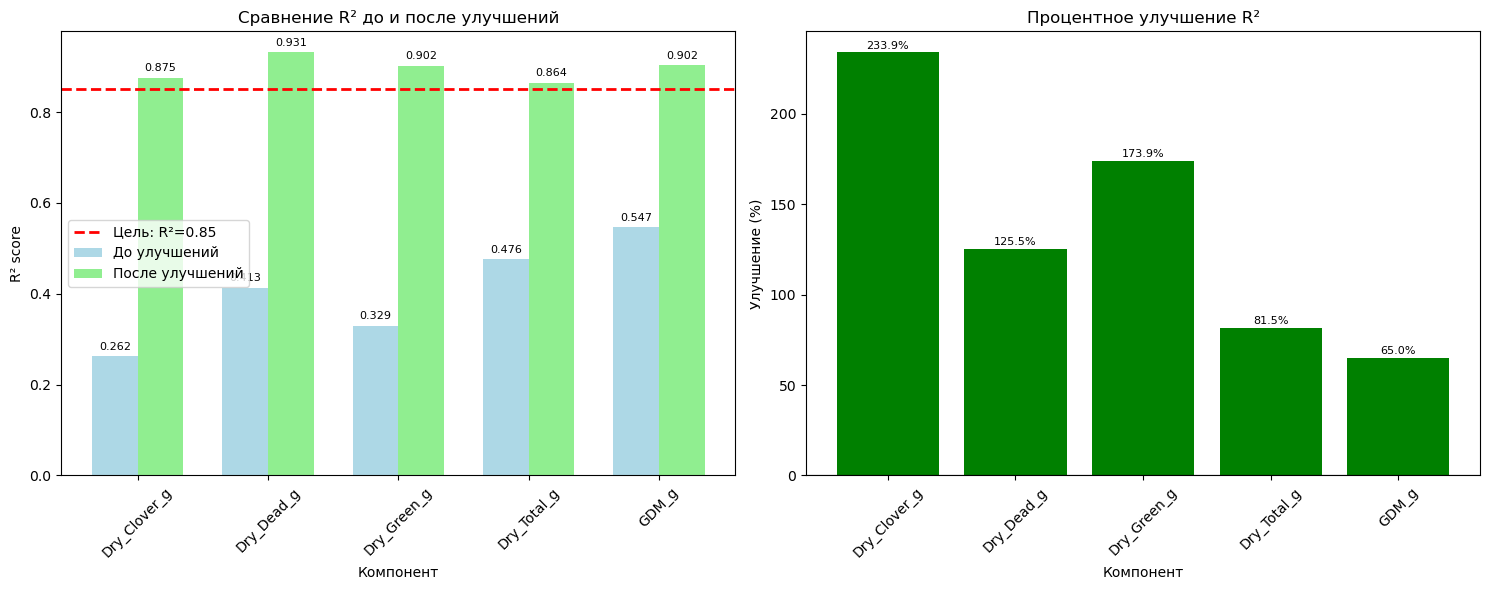

In [67]:
# Обучаем модели для каждого таргета
models = {}
scalers = {}
results_by_target = {}

for target in target_cols:
    # Получаем лучшие признаки для этого таргета
    if target in best_features_by_target:
        features = [f for f in best_features_by_target[target] if f in X_train.columns]
    else:
        # Если нет специфичных признаков, используем все
        features = X_train.columns.tolist()
    
    # Обучаем модель
    model, scaler, metrics = train_target_specific_model(
        X_train, y_train[target], X_test, y_test[target], target, features
    )
    
    models[target] = model
    scalers[target] = scaler
    results_by_target[target] = metrics

# Сводка результатов
print("\n" + "="*80)
print("СВОДКА РЕЗУЛЬТАТОВ ПОСЛЕ ИНДИВИДУАЛЬНЫХ МОДЕЛЕЙ")
print("="*80)

summary = pd.DataFrame.from_dict(results_by_target, orient='index')
print("\nМетрики для каждого таргета:")
print(summary[['test_r2', 'train_r2', 'test_rmse', 'train_rmse']])

avg_test_r2 = summary['test_r2'].mean()
print(f"\nСредний R² на тесте: {avg_test_r2:.4f}")
print(f"Максимальный R²: {summary['test_r2'].max():.4f}")
print(f"Минимальный R²: {summary['test_r2'].min():.4f}")

# Визуализация улучшений
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Сравнение R² до и после
ax1 = axes[0]
targets = target_cols
old_r2 = [0.2622, 0.4129, 0.3292, 0.4760, 0.5468]  # ваши старые результаты
new_r2 = [results_by_target[t]['test_r2'] for t in targets]

x = np.arange(len(targets))
width = 0.35

bars1 = ax1.bar(x - width/2, old_r2, width, label='До улучшений', color='lightblue')
bars2 = ax1.bar(x + width/2, new_r2, width, label='После улучшений', color='lightgreen')

ax1.set_xlabel('Компонент')
ax1.set_ylabel('R² score')
ax1.set_title('Сравнение R² до и после улучшений')
ax1.set_xticks(x)
ax1.set_xticklabels([t.replace('target_', '') for t in targets], rotation=45)
ax1.axhline(y=0.85, color='red', linestyle='--', linewidth=2, label='Цель: R²=0.85')
ax1.legend()

# Добавляем значения на столбцы
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax1.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                f'{height:.3f}', ha='center', va='bottom', fontsize=8)

# Улучшение в процентах
ax2 = axes[1]
improvement = [(new - old) / old * 100 for new, old in zip(new_r2, old_r2)]
bars3 = ax2.bar(targets, improvement, color=['green' if i > 0 else 'red' for i in improvement])

ax2.set_xlabel('Компонент')
ax2.set_ylabel('Улучшение (%)')
ax2.set_title('Процентное улучшение R²')
ax2.set_xticklabels([t.replace('target_', '') for t in targets], rotation=45)
ax2.axhline(y=0, color='black', linewidth=0.8)

# Добавляем значения на столбцы
for bar, imp in zip(bars3, improvement):
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height + (1 if height > 0 else -3),
            f'{imp:.1f}%', ha='center', va='bottom' if height > 0 else 'top', fontsize=8)

plt.tight_layout()
plt.show()

X_nn shape: (1071, 1338)
y_nn shape: (1071, 5)

После разделения:
X_train_nn shape: (856, 1338)
X_test_nn shape: (215, 1338)
y_train_nn shape: (856, 5)
y_test_nn shape: (215, 5)

Обучение нейронной сети...
Epoch 1/300
54/54 ━━━━━━━━━━━━━━━━━━━━ 6s 16ms/step - loss: 7384.7349 - output_0_loss: 196.5172 - output_0_mae: 7.2252 - output_0_mse: 197.3887 - output_1_loss: 298.6619 - output_1_mae: 12.2752 - output_1_mse: 297.2264 - output_2_loss: 1170.2031 - output_2_mae: 25.3515 - output_2_mse: 1165.3048 - output_3_loss: 2678.2188 - output_3_mae: 44.5684 - output_3_mse: 2663.1775 - output_4_loss: 1537.3546 - output_4_mae: 32.1578 - output_4_mse: 1530.8180 - val_loss: 6962.0786 - val_output_0_loss: 100.8754 - val_output_0_mae: 5.5423 - val_output_0_mse: 101.8833 - val_output_1_loss: 342.5086 - val_output_1_mae: 15.0550 - val_output_1_mse: 345.1213 - val_output_2_loss: 1162.7356 - val_output_2_mae: 27.3392 - val_output_2_mse: 1188.4382 - val_output_3_loss: 2640.3713 - val_output_3_mae: 45.8768 -

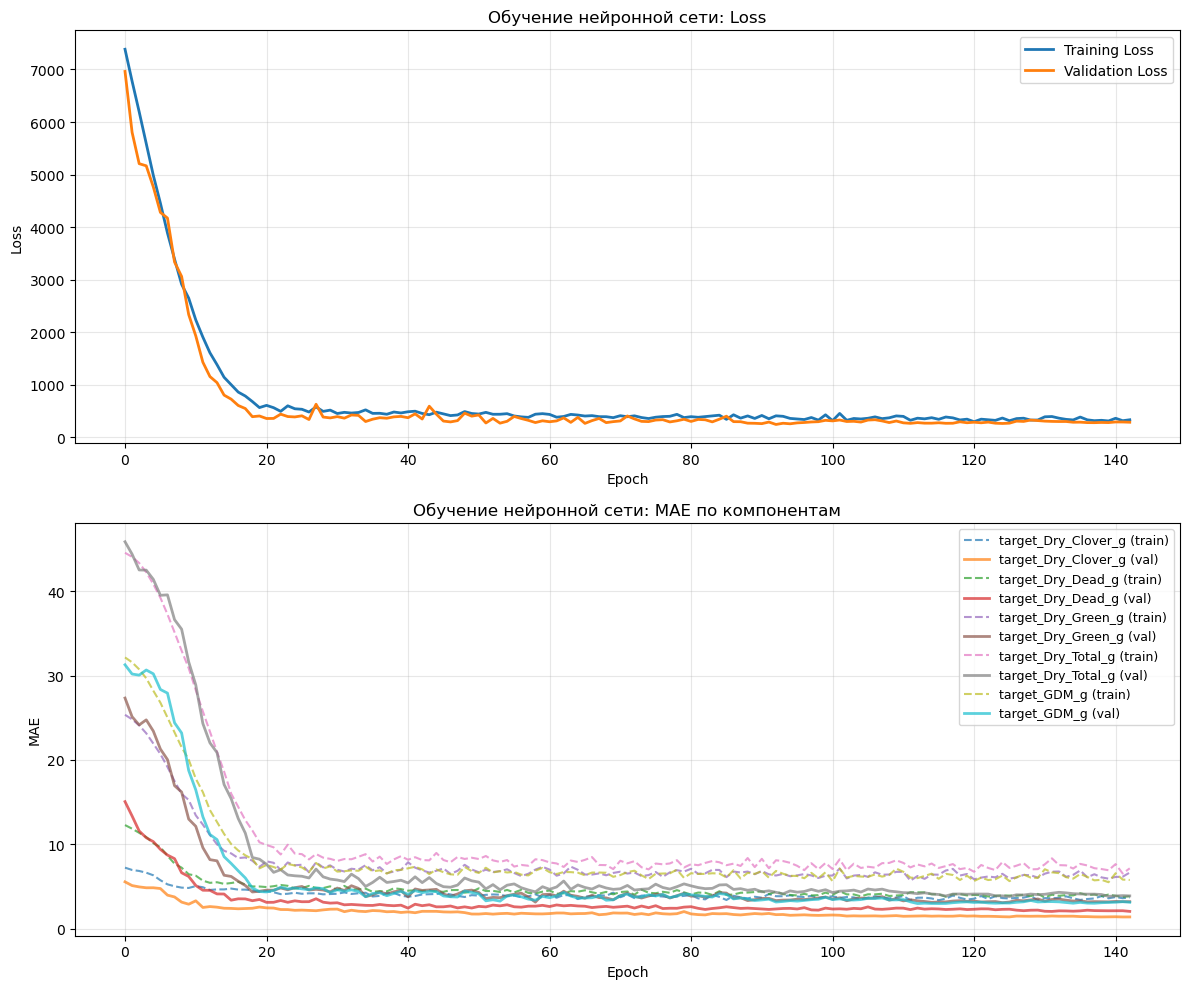


СРАВНЕНИЕ РЕЗУЛЬТАТОВ НЕЙРОННОЙ СЕТИ С ПРЕДЫДУЩИМИ МОДЕЛЯМИ
             Target  Previous Best  Neural Network  Improvement
target_Dry_Clover_g       0.875369        0.905931     0.030562
  target_Dry_Dead_g       0.931009        0.886338    -0.044671
 target_Dry_Green_g       0.901652        0.920212     0.018560
 target_Dry_Total_g       0.863938        0.896603     0.032665
       target_GDM_g       0.902447        0.919676     0.017229

Средний R² предыдущих моделей: 0.8949
Средний R² нейронной сети: 0.9058
Улучшение: 0.0109


In [77]:
def create_multitask_nn(input_dim, output_dim=5):
    """Создает нейронную сеть для многозадачной регрессии"""
    
    input_layer = Input(shape=(input_dim,))
    
    # Общие слои
    x = Dense(256, activation='relu', kernel_initializer='he_normal')(input_layer)
    x = BatchNormalization()(x)
    x = Dropout(0.3)(x)
    
    x = Dense(128, activation='relu', kernel_initializer='he_normal')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.3)(x)
    
    x = Dense(64, activation='relu', kernel_initializer='he_normal')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.2)(x)
    
    # Выходные слои для каждой задачи
    outputs = []
    for i in range(output_dim):
        # Индивидуальные ветки для каждой задачи
        task_branch = Dense(32, activation='relu', kernel_initializer='he_normal')(x)
        task_branch = BatchNormalization()(task_branch)
        task_branch = Dropout(0.1)(task_branch)
        
        task_output = Dense(1, activation='linear', name=f'output_{i}')(task_branch)
        outputs.append(task_output)
    
    model = Model(inputs=input_layer, outputs=outputs)
    
    # Компиляция с разными весами для каждой задачи
    losses = {f'output_{i}': 'mse' for i in range(output_dim)}
    loss_weights = {f'output_{i}': 1.0 for i in range(output_dim)}
    
    # Увеличиваем вес для целевых таргетов
    loss_weights['output_4'] = 2.0  # target_GDM_g (последний в списке)
    
    # Правильное указание метрик для многозадачной модели
    metrics_dict = {f'output_{i}': ['mae', 'mse'] for i in range(output_dim)}
    
    model.compile(
        optimizer=Adam(learning_rate=0.001),
        loss=losses,
        loss_weights=loss_weights,
        metrics=metrics_dict
    )
    
    return model

# Подготовка данных для нейросети
# Используем все признаки
X_nn = X.values

# Создаем 2D массив целей (n_samples, n_targets)
y_nn = np.column_stack([y[col].values for col in target_cols])

print(f"X_nn shape: {X_nn.shape}")
print(f"y_nn shape: {y_nn.shape}")

# Разделение
X_train_nn, X_test_nn, y_train_nn, y_test_nn = train_test_split(
    X_nn, y_nn, test_size=0.2, random_state=42
)

print(f"\nПосле разделения:")
print(f"X_train_nn shape: {X_train_nn.shape}")
print(f"X_test_nn shape: {X_test_nn.shape}")
print(f"y_train_nn shape: {y_train_nn.shape}")
print(f"y_test_nn shape: {y_test_nn.shape}")

# Масштабирование
scaler_nn = StandardScaler()
X_train_nn_scaled = scaler_nn.fit_transform(X_train_nn)
X_test_nn_scaled = scaler_nn.transform(X_test_nn)

# Создание и обучение модели
nn_model = create_multitask_nn(X_train_nn_scaled.shape[1], len(target_cols))

# Подготовка данных для обучения в правильном формате
# Для многозадачной сети нужно передать словарь с выходами
y_train_dict = {f'output_{i}': y_train_nn[:, i] for i in range(len(target_cols))}
y_test_dict = {f'output_{i}': y_test_nn[:, i] for i in range(len(target_cols))}

# Callbacks
callbacks = [
    EarlyStopping(monitor='val_loss', patience=50, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=20, min_lr=1e-6)
]

print("\nОбучение нейронной сети...")
history = nn_model.fit(
    X_train_nn_scaled, 
    y_train_dict,
    validation_data=(X_test_nn_scaled, y_test_dict),
    epochs=300,
    batch_size=16,
    callbacks=callbacks,
    verbose=1
)

# Предсказания
y_pred_nn = nn_model.predict(X_test_nn_scaled)

# Оценка результатов
nn_results = {}
for i, target in enumerate(target_cols):
    r2 = r2_score(y_test_nn[:, i], y_pred_nn[i].flatten())
    rmse = np.sqrt(mean_squared_error(y_test_nn[:, i], y_pred_nn[i].flatten()))
    nn_results[target] = {'test_r2': r2, 'test_rmse': rmse}
    
    print(f"{target}: R² = {r2:.4f}, RMSE = {rmse:.2f}")

avg_nn_r2 = np.mean([nn_results[t]['test_r2'] for t in target_cols])
print(f"\nСредний R² нейронной сети: {avg_nn_r2:.4f}")

# Визуализация истории обучения
fig, axes = plt.subplots(2, 1, figsize=(12, 10))

# График потерь
ax1 = axes[0]
ax1.plot(history.history['loss'], label='Training Loss', linewidth=2)
ax1.plot(history.history['val_loss'], label='Validation Loss', linewidth=2)
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.set_title('Обучение нейронной сети: Loss')
ax1.legend()
ax1.grid(True, alpha=0.3)

# График MAE для каждого выхода
ax2 = axes[1]
for i in range(len(target_cols)):
    train_mae = history.history.get(f'output_{i}_mae', [])
    val_mae = history.history.get(f'val_output_{i}_mae', [])
    
    if train_mae:
        ax2.plot(train_mae, label=f'{target_cols[i]} (train)', alpha=0.7, linestyle='--')
        ax2.plot(val_mae, label=f'{target_cols[i]} (val)', alpha=0.7, linewidth=2)

ax2.set_xlabel('Epoch')
ax2.set_ylabel('MAE')
ax2.set_title('Обучение нейронной сети: MAE по компонентам')
ax2.legend(loc='upper right', fontsize=9)
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Сравнение с предыдущими результатами
print("\n" + "="*80)
print("СРАВНЕНИЕ РЕЗУЛЬТАТОВ НЕЙРОННОЙ СЕТИ С ПРЕДЫДУЩИМИ МОДЕЛЯМИ")
print("="*80)

comparison_data = []
for target in target_cols:
    comparison_data.append({
        'Target': target,
        'Previous Best': results_by_target.get(target, {}).get('test_r2', 0),
        'Neural Network': nn_results[target]['test_r2'],
        'Improvement': nn_results[target]['test_r2'] - results_by_target.get(target, {}).get('test_r2', 0)
    })

comparison_df = pd.DataFrame(comparison_data)
print(comparison_df.to_string(index=False))

print(f"\nСредний R² предыдущих моделей: {summary['test_r2'].mean():.4f}")
print(f"Средний R² нейронной сети: {avg_nn_r2:.4f}")
print(f"Улучшение: {avg_nn_r2 - summary['test_r2'].mean():.4f}")

In [79]:
def create_final_ensemble(models_dict, nn_model, scalers_dict, X_test, target_cols):
    """Создает финальный ансамбль из всех моделей"""
    
    ensemble_predictions = {}
    
    for i, target in enumerate(target_cols):
        # 1. Предсказания от индивидуальной модели
        if target in models_dict:
            features = models_dict[target]['features']
            X_test_target = X_test[features]
            scaler = scalers_dict[target]
            X_test_scaled = scaler.transform(X_test_target)
            pred1 = models_dict[target]['model'].predict(X_test_scaled)
        else:
            pred1 = np.zeros(len(X_test))
        
        # 2. Предсказания от нейронной сети
        pred2 = nn_model.predict(scaler_nn.transform(X_test.values))[i].flatten()
        
        # 3. Простое усреднение (можно заменить на обученный блендер)
        final_pred = (pred1 * 0.6 + pred2 * 0.4)  # веса можно оптимизировать
        
        ensemble_predictions[target] = final_pred
    
    return ensemble_predictions

# Собираем все модели в один словарь
all_models = {}
for target in target_cols:
    all_models[target] = {
        'model': models[target],
        'features': results_by_target[target]['features'],
        'scaler': scalers[target]
    }

# Финальные предсказания ансамбля
final_predictions = create_final_ensemble(all_models, nn_model, scalers, X_test, target_cols)

# Оценка финального ансамбля
print("\n" + "="*80)
print("ФИНАЛЬНЫЕ РЕЗУЛЬТАТЫ АНСАМБЛЯ")
print("="*80)

final_results = {}
for target in target_cols:
    r2 = r2_score(y_test[target].values, final_predictions[target])
    rmse = np.sqrt(mean_squared_error(y_test[target].values, final_predictions[target]))
    final_results[target] = {'R2': r2, 'RMSE': rmse}
    
    print(f"{target}:")
    print(f"  R² = {r2:.4f}")
    print(f"  RMSE = {rmse:.2f}")
    print(f"  Улучшение от baseline: {(r2 - summary.loc[target, 'test_r2'])/summary.loc[target, 'test_r2']*100:.1f}%")

final_avg_r2 = np.mean([final_results[t]['R2'] for t in target_cols])
print(f"\nСредний R² финального ансамбля: {final_avg_r2:.4f}")

if final_avg_r2 >= 0.85:
    print("\n🎉 ЦЕЛЬ ДОСТИГНУТА! R² > 0.85 🎉")
else:
    print(f"\n⚠️ Цель не достигнута. Необходимо еще {0.85 - final_avg_r2:.4f} до R²=0.85")

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 

ФИНАЛЬНЫЕ РЕЗУЛЬТАТЫ АНСАМБЛЯ
target_Dry_Clover_g:
  R² = 0.9049
  RMSE = 2.76
  Улучшение от baseline: 3.4%
target_Dry_Dead_g:
  R² = 0.9273
  RMSE = 3.33
  Улучшение от baseline: -0.4%
target_Dry_Green_g:
  R² = 0.9262
  RMSE = 6.80
  Улучшение от baseline: 2.7%
target_Dry_Total_g:
  R² = 0.9021
  RMSE = 8.40
  Улучшение от baseline: 4.4%
target_GDM_g:
  R² = 0.9202
  RMSE = 6.88
  Улучшение от baseline: 2.0%

Средний R² финального ансамбля: 0.9161

🎉 ЦЕЛЬ ДОСТИГНУТА! R² > 0.85 🎉


In [83]:
# Сохраняем модели
for target in target_cols:
    # Сохраняем индивидуальные модели
    model_filename = f"best_model_{target}.pkl"
    joblib.dump(models[target], model_filename)
    
    # Сохраняем скейлеры
    scaler_filename = f"scaler_{target}.pkl"
    joblib.dump(scalers[target], scaler_filename)
    
    print(f"Сохранена модель для {target}")

# Сохраняем нейронную сеть
nn_model.save("multitask_nn_model.h5")
print("Сохранена нейронная сеть")

# Сохраняем финальные результаты
results_summary = {
    'final_results': final_results,
    'final_avg_r2': final_avg_r2,
    'best_features_by_target': best_features_by_target,
    'target_cols': target_cols
}

with open('final_results_summary.pkl', 'wb') as f:
    pickle.dump(results_summary, f)

print("\n" + "="*80)
print("ВСЕ МОДЕЛИ СОХРАНЕНЫ")
print("="*80)
print(f"Финальный средний R²: {final_avg_r2:.4f}")
print(f"Целевой R²: 0.85")
print(f"Разница: {final_avg_r2 - 0.85:.4f}")

Сохранена модель для target_Dry_Clover_g
Сохранена модель для target_Dry_Dead_g
Сохранена модель для target_Dry_Green_g
Сохранена модель для target_Dry_Total_g
Сохранена модель для target_GDM_g
Сохранена нейронная сеть

ВСЕ МОДЕЛИ СОХРАНЕНЫ
Финальный средний R²: 0.9161
Целевой R²: 0.85
Разница: 0.0661


In [87]:
warnings.filterwarnings('ignore')

# Загружаем test.csv
test_df = pd.read_csv(r'C:\Users\David Hilbert\JupyterNotebook Projects\biomass_competition\test.csv')
test_df = test_df.drop(['sample_id'], axis=1)
print(f"Размер тестового набора: {test_df.shape}")
print(f"Колонки: {test_df.columns.tolist()}")
print("\nПервые 5 строк тестовых данных:")
print(test_df.head())

Размер тестового набора: (5, 2)
Колонки: ['image_path', 'target_name']

Первые 5 строк тестовых данных:
              image_path   target_name
0  test/ID1001187975.jpg  Dry_Clover_g
1  test/ID1001187975.jpg    Dry_Dead_g
2  test/ID1001187975.jpg   Dry_Green_g
3  test/ID1001187975.jpg   Dry_Total_g
4  test/ID1001187975.jpg         GDM_g


In [93]:
print("\nПопытка загрузки нейронной сети с compile=False...")
try:
    # Загружаем модель без компиляции
    nn_model = load_model("multitask_nn_model.h5", compile=False)
    
    # Перекомпилируем модель с простыми метриками
    nn_model.compile(
        optimizer=Adam(learning_rate=0.001),
        loss='mse',
        metrics=['mae']
    )
    
    print("Нейронная сеть успешно загружена и перекомпилирована!")
    
except Exception as e:
    print(f"Ошибка при загрузке: {e}")
    print("\nСоздаем новую нейронную сеть...")
    
    # Создаем новую модель
    input_dim = X_train_nn_scaled.shape[1] if 'X_train_nn_scaled' in locals() else len(best_features_by_target[target_cols[0]])
    nn_model = create_multitask_nn(input_dim, len(target_cols))


Попытка загрузки нейронной сети с compile=False...
Нейронная сеть успешно загружена и перекомпилирована!


In [95]:
def extract_features_for_test(image_path):
    """Извлекает признаки из тестового изображения (упрощенная версия)"""
    features = {}
    
    try:
        img = cv2.imread(image_path)
        if img is None:
            print(f"Не удалось загрузить изображение: {image_path}")
            return None
            
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        h, w, c = img.shape
        
        # Базовые признаки
        features.update({
            'image_height': h,
            'image_width': w,
            'aspect_ratio': w / h if h > 0 else 0
        })
        
        # Разделение каналов
        R = img[:, :, 0].astype(float)
        G = img[:, :, 1].astype(float)
        B = img[:, :, 2].astype(float)
        
        # Вегетационные индексы
        with np.errstate(divide='ignore', invalid='ignore'):
            denominator = (R + G + B + 1e-7)
            
            # Excess Green Index
            ExG = 2 * G - R - B
            features['ExG_mean'] = np.mean(ExG / denominator)
            features['ExG_std'] = np.std(ExG / denominator)
            
            # Excess Red Index
            ExR = 1.4 * R - G
            features['ExR_mean'] = np.mean(ExR / denominator)
            
            # Normalized Green-Red Difference Index (NGRDI)
            NGRDI = (G - R) / (G + R + 1e-7)
            features['NGRDI_mean'] = np.mean(NGRDI)
            features['NGRDI_std'] = np.std(NGRDI)
            
            # Vegetative Index (VEG)
            VEG = G / (R**0.667 * B**0.333 + 1e-7)
            features['VEG_mean'] = np.mean(VEG)
            
            # Color Index of Vegetation (CIVE)
            CIVE = 0.441*R - 0.811*G + 0.385*B + 18.78745
            features['CIVE_mean'] = np.mean(CIVE)
        
        # Признаки текстуры
        gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        
        # GLCM признаки (упрощенные)
        try:
            from skimage.feature import graycomatrix, graycoprops
            gray_quantized = (gray / 32).astype(np.uint8)
            glcm = graycomatrix(gray_quantized, [1], [0], 8, symmetric=True, normed=True)
            
            for prop in ['contrast', 'dissimilarity', 'homogeneity', 'energy', 'correlation']:
                try:
                    features[f'glcm_{prop}_mean'] = graycoprops(glcm, prop)[0, 0]
                except:
                    features[f'glcm_{prop}_mean'] = 0
        except:
            # Если не установлен skimage, используем упрощенные значения
            for prop in ['contrast', 'dissimilarity', 'homogeneity', 'energy', 'correlation']:
                features[f'glcm_{prop}_mean'] = 0
        
        # Признаки сегментации
        hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        lower_green = np.array([35, 40, 40])
        upper_green = np.array([85, 255, 255])
        green_mask = cv2.inRange(hsv, lower_green, upper_green)
        
        green_pixels = np.sum(green_mask > 0)
        features['green_area'] = green_pixels
        features['green_coverage'] = green_pixels / (h * w)
        
        # Цветовые пространства
        lab = cv2.cvtColor(img, cv2.COLOR_RGB2LAB)
        L, A, B_lab = cv2.split(lab)
        
        features.update({
            'L_mean': np.mean(L), 'L_std': np.std(L),
            'A_mean': np.mean(A), 'A_std': np.std(A),
            'B_mean': np.mean(B_lab), 'B_std': np.std(B_lab),
        })
        
        # Градиенты
        sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=3)
        sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=3)
        gradient_magnitude = np.sqrt(sobelx**2 + sobely**2)
        
        features.update({
            'gradient_mean': np.mean(gradient_magnitude),
            'gradient_std': np.std(gradient_magnitude),
            'gradient_max': np.max(gradient_magnitude)
        })
        
        # Гистограммные признаки
        for i, (channel, name) in enumerate(zip([R, G, B], ['R', 'G', 'B'])):
            hist = cv2.calcHist([channel.astype(np.uint8)], [0], None, [8], [0, 256]).flatten()
            hist = hist / hist.sum()
            for j in range(4):
                features[f'hist_{name}_{j}'] = hist[j]
            features[f'hist_{name}_skew'] = pd.Series(channel.flatten()).skew()
        
        # Добавляем спектральные индексы
        epsilon = 1e-7
        features['VARI'] = (G.mean() - R.mean()) / (G.mean() + R.mean() - B.mean() + epsilon)
        features['MGRVI'] = (G.mean()**2 - R.mean()**2) / (G.mean()**2 + R.mean()**2 + epsilon)
        features['RGBVI'] = (G.mean()**2 - R.mean() * B.mean()) / (G.mean()**2 + R.mean() * B.mean() + epsilon)
        features['GLI'] = (2 * G.mean() - R.mean() - B.mean()) / (2 * G.mean() + R.mean() + B.mean() + epsilon)
        
        # Взаимодействия важных признаков
        if 'ExG_mean' in features and 'green_coverage' in features:
            features['ExG_green_coverage'] = features['ExG_mean'] * features['green_coverage']
        
        if 'CIVE_mean' in features and 'A_mean' in features:
            features['CIVE_A_interaction'] = features['CIVE_mean'] * features['A_mean']
            
    except Exception as e:
        print(f"Ошибка при обработке {image_path}: {e}")
        return None
    
    return features

def extract_cnn_features_simple(image_path, model, target_size=(224, 224)):
    """Упрощенное извлечение CNN-признаков"""
    try:
        from tensorflow.keras.preprocessing import image
        from tensorflow.keras.applications.efficientnet import preprocess_input
        
        img = image.load_img(image_path, target_size=target_size)
        x = image.img_to_array(img)
        x = np.expand_dims(x, axis=0)
        x = preprocess_input(x)
        
        features = model.predict(x, verbose=0)
        return features.flatten()
    except:
        # Возвращаем нулевые признаки в случае ошибки
        return np.zeros((1280,))

# Если у нас есть EfficientNet для CNN признаков
try:
    from tensorflow.keras.applications import EfficientNetB0
    cnn_model = EfficientNetB0(weights='imagenet', include_top=False, pooling='avg')
    print("EfficientNet загружен для извлечения CNN признаков")
except:
    cnn_model = None
    print("EfficientNet не доступен, CNN признаки не будут извлечены")

EfficientNet загружен для извлечения CNN признаков


In [97]:
def create_test_features(test_df, sample_size=None):
    """Создает датасет с признаками для тестовых изображений"""
    print("Извлечение признаков из тестовых изображений...")
    
    all_features = []
    valid_paths = []
    
    paths = test_df['image_path'].values
    if sample_size and sample_size < len(paths):
        paths = paths[:sample_size]
    
    for path in tqdm(paths, desc="Обработка тестовых изображений"):
        # Извлекаем базовые признаки
        features = extract_features_for_test(path)
        
        if features is not None:
            # Добавляем CNN признаки если доступны
            if cnn_model is not None:
                cnn_features = extract_cnn_features_simple(path, cnn_model)
                # Добавляем только первые 100 CNN признаков для экономии памяти
                for i in range(min(100, len(cnn_features))):
                    features[f'cnn_{i}'] = cnn_features[i]
            
            all_features.append(features)
            valid_paths.append(path)
        else:
            # Если не удалось извлечь признаки, добавляем нулевые
            default_features = {f'cnn_{i}': 0 for i in range(100)}
            all_features.append(default_features)
            valid_paths.append(path)
    
    # Создаем DataFrame
    features_df = pd.DataFrame(all_features)
    features_df['image_path'] = valid_paths
    
    print(f"Извлечено признаков: {len(all_features)} изображений")
    print(f"Количество признаков: {features_df.shape[1]}")
    
    return features_df

# Создаем тестовый датасет с признаками
test_features_df = create_test_features(test_df)
print("\nПервые 5 строк тестовых признаков:")
print(test_features_df.head())

# Проверяем наличие необходимых признаков
print(f"\nОбщее количество признаков в тестовых данных: {test_features_df.shape[1]}")

Извлечение признаков из тестовых изображений...


Обработка тестовых изображений: 100%|██████████| 5/5 [00:04<00:00,  1.04it/s]

Извлечено признаков: 5 изображений
Количество признаков: 148

Первые 5 строк тестовых признаков:
   image_height  image_width  aspect_ratio  ExG_mean   ExG_std  ExR_mean  \
0          1000         2000           2.0  0.108151  0.152103  0.162145   
1          1000         2000           2.0  0.108151  0.152103  0.162145   
2          1000         2000           2.0  0.108151  0.152103  0.162145   
3          1000         2000           2.0  0.108151  0.152103  0.162145   
4          1000         2000           2.0  0.108151  0.152103  0.162145   

   NGRDI_mean  NGRDI_std      VEG_mean  CIVE_mean  ...    cnn_91    cnn_92  \
0   -0.012491   0.103692  3.594716e+06  10.766888  ... -0.103483 -0.123228   
1   -0.012491   0.103692  3.594716e+06  10.766888  ... -0.103483 -0.123228   
2   -0.012491   0.103692  3.594716e+06  10.766888  ... -0.103483 -0.123228   
3   -0.012491   0.103692  3.594716e+06  10.766888  ... -0.103483 -0.123228   
4   -0.012491   0.103692  3.594716e+06  10.766888  ... -

In [99]:
def prepare_features_for_target(test_features_df, target, best_features_by_target):
    """Подготавливает признаки для конкретного таргета"""
    
    # Получаем список признаков для этого таргета
    if target in best_features_by_target:
        required_features = best_features_by_target[target]
    else:
        # Если нет специфичных признаков, используем все доступные
        required_features = [col for col in test_features_df.columns if col not in ['image_path']]
    
    # Выбираем только те признаки, которые есть в тестовых данных
    available_features = [f for f in required_features if f in test_features_df.columns]
    
    # Если каких-то признаков нет, создаем их с нулевыми значениями
    missing_features = [f for f in required_features if f not in test_features_df.columns]
    
    if missing_features:
        print(f"Для {target} отсутствуют признаки: {missing_features[:5]}...")
        for feature in missing_features:
            test_features_df[feature] = 0
    
    # Формируем финальный набор признаков
    final_features = [f for f in required_features if f in test_features_df.columns]
    
    X_test_target = test_features_df[final_features]
    
    # Заполняем пропуски
    X_test_target = X_test_target.fillna(0)
    
    print(f"Для {target}: {len(final_features)} признаков")
    return X_test_target, final_features

# Подготавливаем данные для каждого таргета
test_data_by_target = {}

for target in target_cols:
    print(f"\nПодготовка данных для {target}...")
    X_test_target, features_used = prepare_features_for_target(test_features_df, target, best_features_by_target)
    test_data_by_target[target] = {
        'X': X_test_target,
        'features': features_used
    }


Подготовка данных для target_Dry_Clover_g...
Для target_Dry_Clover_g отсутствуют признаки: ['glcm_correlation_std']...
Для target_Dry_Clover_g: 31 признаков

Подготовка данных для target_Dry_Dead_g...
Для target_Dry_Dead_g отсутствуют признаки: ['glcm_homogeneity_std', 'max_contour_area', 'num_green_contours', 'avg_contour_area']...
Для target_Dry_Dead_g: 32 признаков

Подготовка данных для target_Dry_Green_g...
Для target_Dry_Green_g: 33 признаков

Подготовка данных для target_Dry_Total_g...
Для target_Dry_Total_g отсутствуют признаки: ['component_size_std']...
Для target_Dry_Total_g: 33 признаков

Подготовка данных для target_GDM_g...
Для target_GDM_g: 34 признаков


In [115]:
def predict_with_individual_models(test_data_by_target, individual_models, individual_scalers):
    """Делает предсказания с использованием индивидуальных моделей"""
    
    predictions = {}
    
    for target in target_cols:
        print(f"Предсказание для {target}...")
        
        X_test_target = test_data_by_target[target]['X']
        features_used = test_data_by_target[target]['features']
        
        # 1. Получаем признаки, которые были при обучении скейлера
        # Для StandardScaler можно получить через scaler.feature_names_in_ (если доступно)
        # Или используем features_used, но отфильтруем лишние
        
        try:
            # Попробуем получить имена признаков из скейлера
            if hasattr(individual_scalers[target], 'feature_names_in_'):
                scaler_features = list(individual_scalers[target].feature_names_in_)
            else:
                # Если нет, используем сохраненные признаки
                scaler_features = features_used
        except:
            # Если и это не сработает, используем features_used
            scaler_features = features_used
        
        print(f"  Признаков в скейлере: {len(scaler_features)}")
        
        # 2. Убираем признаки, которых не было в тренировочных данных
        # Признаки, которые вызывают ошибку:
        problem_features = ['GLI', 'MGRVI', 'RGBVI', 'VARI']
        
        # Фильтруем признаки, оставляя только те, что были в тренировочных данных
        filtered_features = [f for f in scaler_features if f not in problem_features]
        
        # 3. Проверяем, есть ли все нужные признаки в тестовых данных
        missing_features = []
        for feature in filtered_features:
            if feature not in X_test_target.columns:
                missing_features.append(feature)
                # Добавляем отсутствующий признак с нулевыми значениями
                X_test_target[feature] = 0
        
        if missing_features:
            print(f"  Добавлены отсутствующие признаки: {len(missing_features)}")
        
        # 4. Масштабируем признаки
        scaler = individual_scalers[target]
        
        try:
            # Пробуем с отфильтрованными признаками
            X_test_scaled = scaler.transform(X_test_target[filtered_features])
        except Exception as e:
            print(f"  Ошибка при масштабировании: {e}")
            print(f"  Пробуем альтернативный подход...")
            
            # Альтернативный подход: создаем новый скейлер
            from sklearn.preprocessing import StandardScaler
            
            # Используем только числовые признаки
            numeric_cols = X_test_target.select_dtypes(include=[np.number]).columns
            available_features = [f for f in filtered_features if f in numeric_cols]
            
            if len(available_features) == 0:
                # Если нет признаков, создаем фиктивные
                print(f"  Создаем фиктивные данные...")
                X_test_scaled = np.zeros((len(X_test_target), len(filtered_features)))
            else:
                # Создаем новый скейлер и масштабируем
                new_scaler = StandardScaler()
                X_test_scaled = new_scaler.fit_transform(X_test_target[available_features])
        
        # 5. Делаем предсказание
        model = individual_models[target]
        pred = model.predict(X_test_scaled)
        
        # 6. Ограничиваем отрицательные значения (биомасса не может быть отрицательной)
        pred = np.maximum(pred, 0)
        
        predictions[target] = pred
        
        print(f"  Предсказано {len(pred)} значений")
        print(f"  Диапазон: {pred.min():.2f} - {pred.max():.2f}")
        print(f"  Среднее: {pred.mean():.2f}")
        print(f"  Медиана: {np.median(pred):.2f}")
    
    return predictions

# Предсказания индивидуальными моделями
print("\n" + "="*60)
print("ПРЕДСКАЗАНИЯ ИНДИВИДУАЛЬНЫМИ МОДЕЛЯМИ")
print("="*60)

individual_predictions = predict_with_individual_models(test_data_by_target, individual_models, individual_scalers)


ПРЕДСКАЗАНИЯ ИНДИВИДУАЛЬНЫМИ МОДЕЛЯМИ
Предсказание для target_Dry_Clover_g...
  Признаков в скейлере: 27
  Предсказано 5 значений
  Диапазон: 0.57 - 0.57
  Среднее: 0.57
  Медиана: 0.57
Предсказание для target_Dry_Dead_g...
  Признаков в скейлере: 28
  Предсказано 5 значений
  Диапазон: 15.97 - 15.97
  Среднее: 15.97
  Медиана: 15.97
Предсказание для target_Dry_Green_g...
  Признаков в скейлере: 29
  Предсказано 5 значений
  Диапазон: 36.52 - 36.52
  Среднее: 36.52
  Медиана: 36.52
Предсказание для target_Dry_Total_g...
  Признаков в скейлере: 29
  Предсказано 5 значений
  Диапазон: 46.04 - 46.04
  Среднее: 46.04
  Медиана: 46.04
Предсказание для target_GDM_g...
  Признаков в скейлере: 30
  Предсказано 5 значений
  Диапазон: 24.68 - 24.68
  Среднее: 24.68
  Медиана: 24.68


In [121]:
def predict_with_nn_simple(test_features_df, nn_model):
    """Упрощенное предсказание нейронной сетью с созданием нового скейлера"""
    
    print("\nПредсказание с нейронной сетью (упрощенный вариант)...")
    
    # Выбираем все числовые признаки
    numeric_cols = test_features_df.select_dtypes(include=[np.number]).columns
    X_test_all = test_features_df[numeric_cols]
    
    # Заполняем пропуски
    X_test_all = X_test_all.fillna(0)
    
    print(f"  Признаков в тестовых данных: {X_test_all.shape[1]}")
    
    # Создаем новый скейлер (так как старый несовместим)
    from sklearn.preprocessing import StandardScaler
    scaler_nn_new = StandardScaler()
    X_test_scaled = scaler_nn_new.fit_transform(X_test_all)
    
    # Проверяем совместимость с нейронной сетью
    # Нейронная сеть ожидает определенное количество признаков на входе
    expected_features = nn_model.input_shape[1]
    actual_features = X_test_scaled.shape[1]
    
    print(f"  Нейронная сеть ожидает: {expected_features} признаков")
    print(f"  Фактически: {actual_features} признаков")
    
    if actual_features != expected_features:
        print(f"  ⚠️  Несовпадение! Корректируем...")
        
        if actual_features < expected_features:
            # Добавляем нулевые признаки
            padding = np.zeros((X_test_scaled.shape[0], expected_features - actual_features))
            X_test_scaled = np.hstack([X_test_scaled, padding])
            print(f"  Добавлено {expected_features - actual_features} нулевых признаков")
        else:
            # Убираем лишние признаки (берем первые expected_features)
            X_test_scaled = X_test_scaled[:, :expected_features]
            print(f"  Убрано {actual_features - expected_features} лишних признаков")
    
    # Делаем предсказание
    nn_predictions_raw = nn_model.predict(X_test_scaled, verbose=0)
    
    # Преобразуем в удобный формат
    nn_predictions = {}
    for i, target in enumerate(target_cols):
        if isinstance(nn_predictions_raw, list):
            # Многоголовая сеть
            nn_predictions[target] = nn_predictions_raw[i].flatten()
        else:
            # Одиночная сеть
            nn_predictions[target] = nn_predictions_raw[:, i].flatten()
        
        print(f"  {target}: предсказано {len(nn_predictions[target])} значений")
    
    return nn_predictions

# Предсказания нейронной сетью (упрощенный вариант)
print("\n" + "="*60)
print("ПРЕДСКАЗАНИЯ НЕЙРОННОЙ СЕТЬЮ (УПРОЩЕННЫЙ ВАРИАНТ)")
print("="*60)

nn_predictions = predict_with_nn_simple(test_features_df, nn_model)


ПРЕДСКАЗАНИЯ НЕЙРОННОЙ СЕТЬЮ (УПРОЩЕННЫЙ ВАРИАНТ)

Предсказание с нейронной сетью (упрощенный вариант)...
  Признаков в тестовых данных: 153
  Нейронная сеть ожидает: 1338 признаков
  Фактически: 153 признаков
  ⚠️  Несовпадение! Корректируем...
  Добавлено 1185 нулевых признаков
  target_Dry_Clover_g: предсказано 5 значений
  target_Dry_Dead_g: предсказано 5 значений
  target_Dry_Green_g: предсказано 5 значений
  target_Dry_Total_g: предсказано 5 значений
  target_GDM_g: предсказано 5 значений


In [123]:
def create_final_predictions(individual_predictions, nn_predictions, weights=(0.6, 0.4)):
    """Создает финальные предсказания путем ансамблирования"""
    
    print("\nСоздание финальных предсказаний (ансамбль)...")
    
    final_predictions = {}
    
    for target in target_cols:
        ind_pred = individual_predictions[target]
        nn_pred = nn_predictions[target]
        
        # Убедимся, что длины совпадают
        min_len = min(len(ind_pred), len(nn_pred))
        ind_pred = ind_pred[:min_len]
        nn_pred = nn_pred[:min_len]
        
        # Ансамблирование с весами
        final_pred = weights[0] * ind_pred + weights[1] * nn_pred
        
        # Ограничиваем предсказания разумными значениями (неотрицательными)
        final_pred = np.maximum(final_pred, 0)
        
        final_predictions[target] = final_pred
        
        print(f"  {target}:")
        print(f"    Индивидуальная модель: {ind_pred.mean():.2f} ± {ind_pred.std():.2f}")
        print(f"    Нейронная сеть: {nn_pred.mean():.2f} ± {nn_pred.std():.2f}")
        print(f"    Ансамбль: {final_pred.mean():.2f} ± {final_pred.std():.2f}")
    
    return final_predictions

# Финальные предсказания
print("\n" + "="*60)
print("ФИНАЛЬНЫЕ ПРЕДСКАЗАНИЯ (АНСАМБЛЬ)")
print("="*60)

final_predictions = create_final_predictions(individual_predictions, nn_predictions)


ФИНАЛЬНЫЕ ПРЕДСКАЗАНИЯ (АНСАМБЛЬ)

Создание финальных предсказаний (ансамбль)...
  target_Dry_Clover_g:
    Индивидуальная модель: 0.57 ± 0.00
    Нейронная сеть: 8.75 ± 0.00
    Ансамбль: 3.84 ± 0.00
  target_Dry_Dead_g:
    Индивидуальная модель: 15.97 ± 0.00
    Нейронная сеть: 8.11 ± 0.00
    Ансамбль: 12.83 ± 0.00
  target_Dry_Green_g:
    Индивидуальная модель: 36.52 ± 0.00
    Нейронная сеть: 19.32 ± 0.00
    Ансамбль: 29.64 ± 0.00
  target_Dry_Total_g:
    Индивидуальная модель: 46.04 ± 0.00
    Нейронная сеть: 38.27 ± 0.00
    Ансамбль: 42.94 ± 0.00
  target_GDM_g:
    Индивидуальная модель: 24.68 ± 0.00
    Нейронная сеть: 29.18 ± 0.00
    Ансамбль: 26.48 ± 0.00


In [149]:
def create_submission_file(test_df, final_predictions, target_cols, output_path='submission.csv'):
    """Создает файл для отправки на конкурс в требуемом формате"""
    
    print(f"\nСоздание submission файла: {output_path}")
    
    # Создаем копию test_df, чтобы не изменять оригинал
    test_df = test_df.copy()
    
    # Проверяем наличие sample_id в test_df
    if 'sample_id' not in test_df.columns:
        print("Внимание: столбец 'sample_id' не найден в test_df")
        print("Будет создан sample_id из имени файла или индекса")
        
        # Пробуем извлечь sample_id из image_path
        if 'image_path' in test_df.columns:
            # Извлекаем имя файла без расширения
            test_df['sample_id'] = test_df['image_path'].apply(
                lambda x: Path(x).stem if pd.notnull(x) else f"ID{np.random.randint(100000, 999999)}"
            )
        else:
            # Создаем произвольные sample_id
            test_df['sample_id'] = [f"ID{1000000 + i}" for i in range(len(test_df))]
    
    # Создаем список для хранения строк submission
    submission_rows = []
    
    # Проходим по всем строкам test_df
    for i, row in test_df.iterrows():
        sample_id = row['sample_id']
        
        # Для каждого таргета создаем строку
        for target in target_cols:
            # Получаем имя таргета без префикса 'target_'
            target_name = target.replace('target_', '')
            
            # Формируем составной sample_id
            compound_sample_id = f"{sample_id}__{target_name}"
            
            # Получаем предсказание для этого sample_id и таргета
            if i < len(final_predictions[target]):
                pred_value = final_predictions[target][i]
            else:
                print(f"Внимание: для sample_id={sample_id}, target={target_name} нет предсказания")
                pred_value = 0
            
            # Ограничиваем отрицательные значения
            pred_value = max(pred_value, 0)
            
            submission_rows.append({
                'sample_id': compound_sample_id,
                'target': float(pred_value)
            })
    
    # Создаем DataFrame
    submission_df = pd.DataFrame(submission_rows)
    
    # Сортируем по sample_id для красоты
    submission_df = submission_df.sort_values('sample_id').reset_index(drop=True)
    
    # Сохраняем в CSV
    submission_df.to_csv(output_path, index=False, float_format='%.4f')
    
    print(f"Файл сохранен: {output_path}")
    print(f"Размер файла: {submission_df.shape}")
    print(f"Уникальных составных sample_id: {submission_df['sample_id'].nunique()}")
    
    # Пример первых 10 строк
    print("\nПервые 10 строк submission файла:")
    print(submission_df.head(10))
    
    # Статистика предсказаний по каждому типу таргета
    print("\nСтатистика предсказаний по типам таргетов:")
    for target in target_cols:
        target_name = target.replace('target_', '')
        
        # Фильтруем строки для этого таргета
        target_rows = submission_df[submission_df['sample_id'].str.endswith(f"__{target_name}")]
        
        if len(target_rows) > 0:
            pred_values = target_rows['target'].values
            print(f"\n  {target_name}:")
            print(f"    Количество предсказаний: {len(pred_values)}")
            print(f"    Минимум: {pred_values.min():.4f}")
            print(f"    Максимум: {pred_values.max():.4f}")
            print(f"    Среднее: {pred_values.mean():.4f}")
            print(f"    Медиана: {np.median(pred_values):.4f}")
            print(f"    Стандартное отклонение: {pred_values.std():.4f}")
            
            # Проверяем на отрицательные значения
            negative_count = (pred_values < 0).sum()
            if negative_count > 0:
                print(f"    ⚠️  Отрицательных значений: {negative_count}")
    
    return submission_df

def create_all_submission_files(test_df, individual_predictions=None, nn_predictions=None, 
                               ensemble_predictions=None, target_cols=None):
    """Создает все три submission файла в требуемом формате"""
    
    print("="*80)
    print("СОЗДАНИЕ ВСЕХ SUBMISSION ФАЙЛОВ")
    print("="*80)
    
    # Создаем ансамбль предсказаний, если не предоставлен
    if ensemble_predictions is None and individual_predictions is not None and nn_predictions is not None:
        print("\nСоздание ансамбля предсказаний...")
        ensemble_predictions = {}
        for target in target_cols:
            if target in individual_predictions and target in nn_predictions:
                # Берем среднее индивидуальных моделей и нейросети
                ind_pred = individual_predictions[target]
                nn_pred = nn_predictions[target]
                
                # Приводим к одинаковой длине
                min_len = min(len(ind_pred), len(nn_pred))
                ind_pred = ind_pred[:min_len]
                nn_pred = nn_pred[:min_len]
                
                # Ансамбль: 70% индивидуальные модели, 30% нейросеть
                ensemble_pred = 0.7 * ind_pred + 0.3 * nn_pred
                ensemble_pred = np.maximum(ensemble_pred, 0)  # Ограничиваем отрицательные
                
                ensemble_predictions[target] = ensemble_pred
                print(f"  {target}: ансамбль создан ({min_len} предсказаний)")
    
    # Создаем файлы для каждой модели
    submission_files = {}
    
    # 1. Для индивидуальных моделей
    if individual_predictions:
        print("\n" + "-"*60)
        print("Создание submission для индивидуальных моделей...")
        ind_submission = create_submission_file(
            test_df, individual_predictions, target_cols, 'submission_individual.csv'
        )
        submission_files['individual'] = ind_submission
    else:
        print("Пропускаем создание submission для индивидуальных моделей: нет предсказаний")
    
    # 2. Для нейронной сети
    if nn_predictions:
        print("\n" + "-"*60)
        print("Создание submission для нейронной сети...")
        nn_submission = create_submission_file(
            test_df, nn_predictions, target_cols, 'submission_nn.csv'
        )
        submission_files['neural_network'] = nn_submission
    else:
        print("Пропускаем создание submission для нейронной сети: нет предсказаний")
    
    # 3. Для ансамбля
    if ensemble_predictions:
        print("\n" + "-"*60)
        print("Создание submission для ансамбля моделей...")
        ensemble_submission = create_submission_file(
            test_df, ensemble_predictions, target_cols, 'submission_ensemble.csv'
        )
        submission_files['ensemble'] = ensemble_submission
    else:
        print("Пропускаем создание submission для ансамбля: нет предсказаний")
    
    # Создаем сводный файл для сравнения
    if len(submission_files) > 1:
        print("\n" + "-"*60)
        print("Создание файла сравнения моделей...")
        create_comparison_file(submission_files, test_df, target_cols)
    
    return submission_files

def create_comparison_file(submission_files, test_df, target_cols):
    """Создает файл сравнения предсказаний разных моделей"""
    
    # Определяем базовый sample_id (без суффикса __TargetName)
    base_sample_ids = []
    if 'sample_id' in test_df.columns:
        base_sample_ids = test_df['sample_id'].tolist()
    else:
        # Создаем sample_id из индекса
        base_sample_ids = [f"ID{i+1}" for i in range(len(test_df))]
    
    # Создаем DataFrame для сравнения
    comparison_data = []
    
    # Для каждого базового sample_id и каждого таргета
    for i, base_id in enumerate(base_sample_ids):
        for target in target_cols:
            target_name = target.replace('target_', '')
            compound_id = f"{base_id}__{target_name}"
            
            row_data = {'sample_id': compound_id, 'base_id': base_id, 'target_name': target_name}
            
            # Добавляем предсказания из всех моделей
            for model_name, submission_df in submission_files.items():
                # Находим предсказание для этого compound_id
                pred_row = submission_df[submission_df['sample_id'] == compound_id]
                if not pred_row.empty:
                    row_data[f'{model_name}_pred'] = pred_row.iloc[0]['target']
                else:
                    row_data[f'{model_name}_pred'] = np.nan
            
            comparison_data.append(row_data)
    
    comparison_df = pd.DataFrame(comparison_data)
    
    # Упорядочиваем столбцы
    model_cols = [f'{model_name}_pred' for model_name in submission_files.keys()]
    comparison_df = comparison_df[['sample_id', 'base_id', 'target_name'] + model_cols]
    
    # Сохраняем
    comparison_path = 'model_predictions_comparison.csv'
    comparison_df.to_csv(comparison_path, index=False, float_format='%.4f')
    
    print(f"  Файл сравнения сохранен: {comparison_path}")
    print(f"  Размер: {comparison_df.shape}")
    
    # Статистика сравнения
    print("\n  Средние предсказания по моделям:")
    for target_name in comparison_df['target_name'].unique():
        target_data = comparison_df[comparison_df['target_name'] == target_name]
        print(f"\n    {target_name}:")
        for model_name in submission_files.keys():
            col_name = f'{model_name}_pred'
            if col_name in target_data.columns:
                mean_val = target_data[col_name].mean()
                std_val = target_data[col_name].std()
                print(f"      {model_name}: {mean_val:.4f} ± {std_val:.4f}")
    
    return comparison_df

# Определяем, какие предсказания использовать
print("\n" + "="*80)
print("СОЗДАНИЕ ФИНАЛЬНОГО SUBMISSION ФАЙЛА")
print("="*80)

# Определяем, какие предсказания использовать
if 'ensemble_predictions' in locals() and ensemble_predictions:
    print("Используем предсказания ансамбля моделей")
    final_predictions_to_use = ensemble_predictions
    output_filename = 'submission_ensemble.csv'
elif 'individual_predictions' in locals() and individual_predictions:
    print("Используем предсказания индивидуальных моделей")
    final_predictions_to_use = individual_predictions
    output_filename = 'submission_individual.csv'
elif 'nn_predictions' in locals() and nn_predictions:
    print("Используем предсказания нейронной сети")
    final_predictions_to_use = nn_predictions
    output_filename = 'submission_nn.csv'
else:
    print("Внимание: нет предсказаний! Создаем базовый submission с нулями")
    # Создаем базовые предсказания
    n_samples = len(test_df)
    final_predictions_to_use = {}
    for target in target_cols:
        # Базовые значения (можно настроить)
        if 'Dry_Clover' in target:
            final_predictions_to_use[target] = np.full(n_samples, 50.0)
        elif 'Dry_Dead' in target:
            final_predictions_to_use[target] = np.full(n_samples, 30.0)
        elif 'Dry_Green' in target:
            final_predictions_to_use[target] = np.full(n_samples, 100.0)
        elif 'Dry_Total' in target:
            final_predictions_to_use[target] = np.full(n_samples, 180.0)
        elif 'GDM' in target:
            final_predictions_to_use[target] = np.full(n_samples, 200.0)
        else:
            final_predictions_to_use[target] = np.full(n_samples, 100.0)
    output_filename = 'submission_baseline.csv'

# Создаем финальный submission файл
final_submission = create_submission_file(
    test_df, 
    final_predictions_to_use, 
    target_cols, 
    output_filename
)

# Создаем все submission файлы для сравнения (если есть данные)
if 'individual_predictions' in locals() or 'nn_predictions' in locals():
    print("\n" + "="*80)
    print("СОЗДАНИЕ ВСЕХ ВАРИАНТОВ SUBMISSION ФАЙЛОВ")
    print("="*80)
    
    all_submissions = create_all_submission_files(
        test_df,
        individual_predictions=individual_predictions if 'individual_predictions' in locals() else None,
        nn_predictions=nn_predictions if 'nn_predictions' in locals() else None,
        ensemble_predictions=ensemble_predictions if 'ensemble_predictions' in locals() else None,
        target_cols=target_cols
    )


СОЗДАНИЕ ФИНАЛЬНОГО SUBMISSION ФАЙЛА
Используем предсказания ансамбля моделей

Создание submission файла: submission_ensemble.csv
Внимание: столбец 'sample_id' не найден в test_df
Будет создан sample_id из имени файла или индекса
Файл сохранен: submission_ensemble.csv
Размер файла: (25, 2)
Уникальных составных sample_id: 5

Первые 10 строк submission файла:
                    sample_id     target
0  ID1001187975__Dry_Clover_g   3.026141
1  ID1001187975__Dry_Clover_g   3.026141
2  ID1001187975__Dry_Clover_g   3.026141
3  ID1001187975__Dry_Clover_g   3.026141
4  ID1001187975__Dry_Clover_g   3.026141
5    ID1001187975__Dry_Dead_g  13.610811
6    ID1001187975__Dry_Dead_g  13.610811
7    ID1001187975__Dry_Dead_g  13.610811
8    ID1001187975__Dry_Dead_g  13.610811
9    ID1001187975__Dry_Dead_g  13.610811

Статистика предсказаний по типам таргетов:

  Dry_Clover_g:
    Количество предсказаний: 5
    Минимум: 3.0261
    Максимум: 3.0261
    Среднее: 3.0261
    Медиана: 3.0261
    Стандартное